In [1]:
import pandas as pd
import numpy as np

In [2]:
df_all = []

In [ ]:
# original R4W TABLE
def get_volume_r4w(df, start_wk, end_wk):
    rolling_window_df = pd.DataFrame([
    {
        'rolling_order':i,
        'rolling_start': end - pd.Timedelta(weeks=4),
        'roling_end':end,
        'rolling_window_range_start': (end - pd.Timedelta(weeks=4)).strftime('%Y-%m-%d') + ' to ' + end.strftime('%Y-%m-%d'),
        'rollingw_window_range_end': end.strftime('%Y-%m-%d') + ' to ' + (end + pd.Timedelta(weeks=4)).strftime('%Y-%m-%d')
    }
    for i, end in enumerate(pd.date_range(start=start_wk, end = end_wk, freq='W-FRI'))])

    #step1 build all accounts x rolling_order combinations
    all_accounts = df_all['account_id'].unique()
    all_orders = rolling_window_df['rolling_order'].unique()
    account_order_grid = pd.MultiIndex.from_product([all_accounts, all_orders], 
                                                    names=['Account ID', 'rolling_order']).to_frame(index=False)
    
    #stept2: compute metrics only where data exists
    volume_records = []
    for acct in df_all['account_id'].unique():
        df_acct = df_all[df_all['account_id'] == acct]
        for _, window in rolling_window_df.iterrows():
            df_window = df_acct[(df_acc['week'] > window['rolling_start']) & (df_acc['week'] <= window['roling_end'])]
            if df_window.empty:
                continue
            a_stock = df_window['a_stock'].sum()
            b_stock = df_window['b_stock'].sum()
            c_stock = df_window['c_stock'].sum()
            total = a_stock + b_stock + c_stock
            a_freq = (df_window['a_stock'] > 0).sum() / df_window['week'].nunique()
            b_freq = (df_window['b_stock'] > 0).sum() / df_window['week'].nunique()
            #c_freq = (df_window['c_stock'] > 0).sum() / df_window['week'].nunique()
            ms_a = a_stock/total if total > 0 else None
            ms_b = b_stock/total if total > 0 else None
            volume_records.append({
                'Account ID': acct,
                'rolling_order': window['rolling_order'],
                'rolling_4w_a_stock': a_stock,
                'rolling_4w_b_stock': b_stock,
                'c_stock': c_stock,
                #'total_stock': total,
                'a_freq': a_freq,
                'b_freq': b_freq,
                #'c_freq': c_freq,
                'rolling_4w_a_ms': ms_a,
                'rolling_4w_a_ms': ms_b,
            })
    volume_partial = pd.DataFrame(volume_records)
    volume_r4w_full = account_order_grid.merge(volume_partial, on=['Account ID', 'rolling_order'], how='left')

    volume_r4w = volume_r4w_full.merge(rolling_window_df, on='rolling_order', how='left')
    metrics_cols = ['rolling_4w_a_stock', 'rolling_4w_b_stock', 'c_stock', 'a_freq', 'b_freq', 
                    'rolling_4w_a_ms', 'rolling_4w_a_ms']
    volume_r4w[metrics_cols] = volume_r4w[metrics_cols].fillna(0)
    volume_r4w = volume_r4w.sort_values(['Account ID', 'rolling_order'])
    volume_r4w = volume_r4w.merge(df_all[['account_id', 'account_name']].drop_duplicates(),
                                left_on='Account ID', right_on='account_id', how='left').drop(columns=['account_id'])
    print(df_all['account_id'].nunique(), volume_r4w['Account ID'].nunique(), len(volume_r4w.groupby(['Account ID'])['rolling_order'].nunique().unique().min()))
    return volume_r4w
    
    

In [ ]:
# spcale up version:
import pandas as pd
import numpy as np

# ✅ 建议：开启 pandas 2.x Copy-on-Write（若版本支持），减少不必要拷贝
# Recommended: enable pandas 2.x copy-on-write (if your version supports it)
pd.options.mode.copy_on_write = True


# def build_r4w_metrics(
#     df: pd.DataFrame,
#     start_wk: str | pd.Timestamp,
#     end_wk: str | pd.Timestamp,
#     *,
#     week_col: str = "week",
#     id_col: str = "account_id",
#     name_col: str = "account_name",
#     a_col: str = "a_stock",
#     b_col: str = "b_stock",
#     c_col: str = "c_stock",
#     freq_denominator: str = "fixed4"  # "fixed4"（默认，分母恒等于4）或 "observed"（分母=窗口内实际观测周数）
# ) -> pd.DataFrame:
    
def build_r4w_metrics(
    df,
    start_wk,
    end_wk,
    *,
    week_col="week",
    id_col="account_id",
    name_col="account_name",
    a_col="a_stock",
    b_col="b_stock",
    c_col="c_stock",
    freq_denominator="fixed4"
) -> pd.DataFrame:

    """
    生成以“周五”为窗口终点的 R4W（滚动4周）指标（纯 pandas 向量化、高性能）
    Build R4W (rolling 4 weeks) metrics with Friday as window end (pure pandas, vectorized & fast)

    输入 Input
    -----
    df : 包含原始周度数据的 DataFrame；需包含：
         DataFrame with weekly rows; must contain:
         - id_col（门店/账户ID；e.g., "account_id"）
         - name_col（门店名；e.g., "account_name"）
         - week_col（周日期；可为YYYYMMDD/字符串/日期；会对齐到该周“周五”）
         - a_col / b_col（A/B品类销量）
         - c_col（可选；若不存在将按0处理）
    start_wk, end_wk : 统计区间（窗口终点的起/止周五）；如 "2025-01-03", "2025-10-03"
                       Friday range for window ends, e.g. "2025-01-03" to "2025-10-03"
    freq_denominator : "fixed4" 使用固定分母4（推荐，稳定）；"observed" 使用窗口内实际观测周数作为分母
                       Use "fixed4" (recommended) or "observed" for frequency denominator.

    输出 Output
    -----
    返回含以下列的 DataFrame（只保留窗口终点位于 [start_wk, end_wk] 的周五）：
    Returns a DataFrame with Friday window ends within [start_wk, end_wk], including:
      - {id_col}, {name_col}, {week_col}（窗口终点 Friday / window end Friday）
      - rolling_order（窗口序号，按时间1..N / sequential order 1..N）
      - rolling_start, rolling_end（窗口起止；(end-4周, end] / window bounds）
      - rolling_window_range_start / rolling_window_range_end（可读范围 / human-readable ranges）
      - rolling_4w_a_stock / rolling_4w_b_stock / rolling_4w_c_stock（近4周各品类总量 / 4-week sums）
      - total_stock（近4周总量 / 4-week total）
      - a_freq / b_freq / c_freq（近4周“>0的周”占比 / share of positive weeks in last 4）
      - rolling_4w_a_ms / rolling_4w_b_ms（近4周份额 / market share）
    """

    # ---------- 0) 选择所需列 & 统一周日期到“周五” ----------
    # Keep necessary columns only; unify week to the Friday of each week
    base_cols = [id_col, name_col, week_col, a_col, b_col]
    if c_col in df.columns:
        base_cols.append(c_col)
    df = df[base_cols].copy()

    # 将各种 week 表示（YYYYMMDD/字符串/日期）统一为 Timestamp，并对齐到该周周五
    # Normalize 'week' to Timestamp and align to Friday of the week (W-FRI)
    if not np.issubdtype(df[week_col].dtype, np.datetime64):
        s = df[week_col].astype(str)
        is_ymd = s.str.len().eq(8) & s.str.match(r"^\d{8}$")
        df.loc[is_ymd, week_col] = pd.to_datetime(s[is_ymd], format="%Y%m%d", errors="coerce")
        df.loc[~is_ymd, week_col] = pd.to_datetime(s[~is_ymd], errors="coerce")
    df[week_col] = df[week_col].dt.to_period("W-FRI").dt.to_timestamp("W-FRI")

    # ---------- 1) 缺失列与类型压缩 ----------
    # Fill missing c_col with 0 if absent; compress numeric dtypes
    if c_col not in df.columns:
        df[c_col] = 0

    for col in (a_col, b_col, c_col):
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype("Int32")

    # ---------- 2) 生成窗口终点（周五）序列 ----------
    # Build list of Friday window ends within [start_wk, end_wk]
    start_wk = pd.to_datetime(start_wk)
    end_wk = pd.to_datetime(end_wk)
    friday_ends = pd.date_range(start=start_wk, end=end_wk, freq="W-FRI")

    # 由于 rolling(4) 需要往前3周的数据，扩展一个最早日期 earliest_needed
    # For rolling(4), we need 3 more prior weeks
    earliest_needed = friday_ends.min() - pd.Timedelta(weeks=3)

    # ---------- 3) 聚合为“账号×周五”的周表，并对每个账号补齐完整周历 ----------
    # Aggregate to weekly (Friday) per account, then reindex each account to a full Friday calendar
    weekly = (
        df.groupby([id_col, name_col, week_col], as_index=False)[[a_col, b_col, c_col]].sum()
    )

    # def _reindex_one(g: pd.DataFrame) -> pd.DataFrame:
    #     idx = pd.date_range(start=earliest_needed, end=end_wk, freq="W-FRI")
    #     g = g.set_index(week_col).reindex(idx, fill_value=0)
    #     g.index.name = week_col
    #     g = g.reset_index()
    #     g[id_col] = g[id_col].iloc[0]
    #     g[name_col] = g[name_col].iloc[0]
    #     return g[[id_col, name_col, week_col, a_col, b_col, c_col]]
    def _reindex_one(g: pd.DataFrame) -> pd.DataFrame:
    # 先从真实行取出 id/name 常量，避免被补齐行的 0 覆盖
        _id   = g[id_col].iloc[0]
        _name = g[name_col].iloc[0]

        idx = pd.date_range(start=earliest_needed, end=end_wk, freq="W-FRI")

    # 只对数值列做补齐；不要对 id/name 做 fill_value=0
        g_vals = (
            g[[week_col, a_col, b_col, c_col]]
            .set_index(week_col)
            .reindex(idx, fill_value=0)
            .reset_index()
            .rename(columns={"index": week_col})
    )

    # 回写 id/name 常量
        g_vals[id_col] = _id
        g_vals[name_col] = _name

        return g_vals[[id_col, name_col, week_col, a_col, b_col, c_col]]

    weekly_full = (
        weekly.groupby([id_col, name_col], group_keys=False)
              .apply(_reindex_one)
              .reset_index(drop=True)
              .sort_values([id_col, week_col])
    )

    # ---------- 4) 计算 R4W 的 sum / freq / ms（全向量化） ----------
    # Compute rolling-4-week sums, positive frequencies, and market shares (vectorized)
    gb = weekly_full.groupby(id_col, group_keys=False)

    # 近4周 sum（A/B/C）
    a_4 = gb[a_col].rolling(4, min_periods=1).sum().reset_index(drop=True)
    b_4 = gb[b_col].rolling(4, min_periods=1).sum().reset_index(drop=True)
    c_4 = gb[c_col].rolling(4, min_periods=1).sum().reset_index(drop=True)

    weekly_full["rolling_4w_a_stock"] = a_4.astype("float")
    weekly_full["rolling_4w_b_stock"] = b_4.astype("float")
    weekly_full["rolling_4w_c_stock"] = c_4.astype("float")
    weekly_full["total_stock"] = weekly_full["rolling_4w_a_stock"] + weekly_full["rolling_4w_b_stock"] + weekly_full["rolling_4w_c_stock"]

    # 近4周“有货周”计数（>0）/ count of positive weeks in the last 4
    a_pos = gb[a_col].apply(lambda s: (s > 0).rolling(4, min_periods=1).sum()).reset_index(drop=True)
    b_pos = gb[b_col].apply(lambda s: (s > 0).rolling(4, min_periods=1).sum()).reset_index(drop=True)
    c_pos = gb[c_col].apply(lambda s: (s > 0).rolling(4, min_periods=1).sum()).reset_index(drop=True)

    # 频率分母：fixed4 = 4；observed = 窗口内实际观测周数（首个窗口可能<4）
    # Frequency denominator: fixed4=4; observed=actual observed weeks in the window (first windows may be <4)
    if freq_denominator == "observed":
        denom = (gb[week_col].cumcount() + 1).clip(upper=4)
    else:
        denom = pd.Series(4, index=weekly_full.index)

    weekly_full["a_freq"] = (a_pos / denom).astype("float")
    weekly_full["b_freq"] = (b_pos / denom).astype("float")
    weekly_full["c_freq"] = (c_pos / denom).astype("float")

    # 近4周份额（market share）；total=0 时置为 0，避免 NaN/inf
    # 4-week market shares; if total==0, set to 0.0
    with np.errstate(divide="ignore", invalid="ignore"):
        weekly_full["rolling_4w_a_ms"] = np.where(
            weekly_full["total_stock"] > 0,
            weekly_full["rolling_4w_a_stock"] / weekly_full["total_stock"],
            0.0,
        )
        weekly_full["rolling_4w_b_ms"] = np.where(
            weekly_full["total_stock"] > 0,
            weekly_full["rolling_4w_b_stock"] / weekly_full["total_stock"],
            0.0,
        )

    # ---------- 5) 仅保留窗口终点位于 [start_wk, end_wk] 的周五，并生成 rolling_order ----------
    # Keep only Friday ends within [start_wk, end_wk] and add rolling_order
    out = weekly_full[weekly_full[week_col].isin(friday_ends)].copy()
    out = out.sort_values([id_col, week_col])

    ro_map = {d: i + 1 for i, d in enumerate(sorted(friday_ends))}
    out["rolling_order"] = out[week_col].map(ro_map).astype("Int32")

    # 窗口边界与范围（(end-4周, end]）
    # Window bounds and human-readable ranges
    out["rolling_end"] = out[week_col]
    out["rolling_start"] = out["rolling_end"] - pd.Timedelta(weeks=4)
    out["rolling_window_range_start"] = (
        out["rolling_start"].dt.strftime("%Y-%m-%d") + " to " + out["rolling_end"].dt.strftime("%Y-%m-%d")
    )
    out["rolling_window_range_end"] = (
        out["rolling_end"].dt.strftime("%Y-%m-%d") + " to " + (out["rolling_end"] + pd.Timedelta(weeks=4)).dt.strftime("%Y-%m-%d")
    )

    # 输出列顺序 / Final column order
    keep_cols = [
        id_col, name_col, week_col, "rolling_order",
        "rolling_start", "rolling_end",
        "rolling_window_range_start", "rolling_window_range_end",
        "rolling_4w_a_stock", "rolling_4w_b_stock", "rolling_4w_c_stock",
        "total_stock", "a_freq", "b_freq", "c_freq",
        "rolling_4w_a_ms", "rolling_4w_b_ms",
    ]
    out = out.loc[:, keep_cols]

    return out


In [ ]:
volume_r4w = build_r4w_metrics(
    df_all,
    start_wk="2024-05-01",   # 不必是周五；函数会自动对齐到该周“周五”
    end_wk="2025-08-29",     # 这是周五，完美
    freq_denominator="fixed4"  # ✅ 正确参数名
)

In [ ]:
# Original Change Table Version
def get_change_r4w(volume_r4w):
    change_records = []
    volume_r4w['rolling_window_range'] = (
        volume_r4w['rolling_start'].dt.strftime('%Y-%m-%d') + 
        ' to ' 
        + volume_r4w['rolling_end'].dt.strftime('%Y-%m-%d')
    )

    for acct, df_acct in volume_r4w.groupby('Account ID'):
        df_acct = df_acct.sort_values('rolling_order').reset_index(drop=True)
        for i in range(1, len(df_acct)):
            prev = df_acct.iloc[i-1]
            curr = df_acct.iloc[i]

            def pct(now, prev): return round((now - prev)/prev, 2) if pd.notnull(prev) and prev != 0 else 0

            change_records.append({
                'Account ID': acct,
                'rolling_order': curr['rolling_order'],
                'rolling_window_range_start': prev['rolling_window_range'],
                'rolling_window_range_end': curr['rolling_window_range'],
                'change_4w_a_stock': pct(curr['rolling_4w_a_stock'], prev['rolling_4w_a_stock']),
                'change_4w_b_stock': pct(curr['rolling_4w_b_stock'], prev['rolling_4w_b_stock']),
                'change_c_stock': pct(curr['c_stock'] , prev['c_stock']),
                'change_a_freq': pct(curr['a_freq'] , prev['a_freq']),
                'change_b_freq': pct(curr['b_freq'] , prev['b_freq']),
                'change_4w_a_ms': pct(curr['rolling_4w_a_ms'] , prev['rolling_4w_a_ms']),
                'change_4w_b_ms': pct(curr['rolling_4w_b_ms'] , prev['rolling_4w_b_ms']),
            })
    change_r4w = pd.DataFrame(change_records)

    first_b_stocking_orders = (volume_r4w[(volume_r4w['rolling_4w_b_ms'] > 0)]
                               .groupby('Account ID')['rolling_order']
                               .min()
                               .reset_index()
                               .rename(columns={'rolling_order':'first_b_stock_rw'}))
    fallback_orders = (volume_r4w.groupby('Account ID')['rolling_order'].max().reset_index()
                          .rename(columns={'rolling_order':'fallback_order'}))
    first_b_stocking_orders = fallback_orders.merge(first_b_stocking_orders, on='Account ID', how='left')
    first_b_stocking_orders['first_b_stock_rw'] = first_b_stocking_orders['first_b_stock_rw'].fillna(first_b_stocking_orders['fallback_order'])
    change_r4w = change_r4w.merge(first_b_stocking_orders[['Account ID', 'first_b_stock_rw']],
                                  left_on='Account ID', right_on='Account ID', how='left')
    change_r4w = change_r4w.merge(df_all[['Account ID', 'account_name']].drop_duplicates(),
                                left_on='Account ID', right_on='Account ID', how='left')
    return change_r4w

In [ ]:
import pandas as pd
import numpy as np

def get_change_r4w_fast(
    volume_r4w: pd.DataFrame,
    *,
    id_col: str = "account_id",
    name_col: str = "account_name",
    order_col: str = "rolling_order",
    start_col: str = "rolling_start",
    end_col: str = "rolling_end",
    # R4W 指标列（与 build_r4w_metrics 输出保持一致）
    a4_col: str = "rolling_4w_a_stock",
    b4_col: str = "rolling_4w_b_stock",
    c4_col: str = "rolling_4w_c_stock",
    a_freq_col: str = "a_freq",
    b_freq_col: str = "b_freq",
    c_freq_col: str = "c_freq",
    a_ms_col: str = "rolling_4w_a_ms",
    b_ms_col: str = "rolling_4w_b_ms",
    # 是否保留绝对变化（delta）列
    keep_delta: bool = False,
    # 百分比保留小数位
    round_ndigits: int = 2,
):
    """
    生成“相邻滚动窗变化表”（相同账号、相邻 rolling_order 的百分比变化）。
    Vectorized change table between consecutive rolling windows per account.

    变化定义（默认）/ Default change definition:
        pct_change = (curr - prev) / prev
        若 prev==0 或 NaN 则记为 0（避免 inf/NaN）

    输出列 / Output columns:
      - id/name/order
      - rolling_window_range_start: 上一个窗口的 [start, end] 字符串
      - rolling_window_range_end  : 当前窗口的   [start, end] 字符串
      - change_4w_a_stock / change_4w_b_stock / change_4w_c_stock
      - change_a_freq / change_b_freq / change_c_freq
      - change_4w_a_ms / change_4w_b_ms
      - （可选）*_delta 绝对变化列
      - first_b_stock_rw: 每账号首次出现 B 份额>0 的 rolling_order（缺失回退为该账号最大 rolling_order）
    """

    df = volume_r4w.copy()

    # ---------- 0) 安全排序 / sort to ensure consecutive windows ----------
    df = df.sort_values([id_col, order_col], kind="mergesort").reset_index(drop=True)

    # ---------- 1) 生成窗口范围字符串（上、下两个窗） ----------
    # Build readable ranges first
    rng_str = (
        df[start_col].dt.strftime("%Y-%m-%d")
        + " to "
        + df[end_col].dt.strftime("%Y-%m-%d")
    )
    df["__range_str"] = rng_str

    # 上一个窗口（同账号，order-1）的范围与指标 → 使用 groupby().shift(1)
    # Previous window (same account) via shift(1)
    gb = df.groupby(id_col, group_keys=False)

    prev_range = gb["__range_str"].shift(1)
    prev_order = gb[order_col].shift(1)

    # 需要变化的字段列表（在这里统一维护，易扩展）
    metric_cols = [
        a4_col, b4_col, c4_col,
        a_freq_col, b_freq_col, c_freq_col,
        a_ms_col, b_ms_col,
    ]

    # 为每个度量生成 prev、delta、pct_change
    for col in metric_cols:
        df[f"__prev_{col}"]  = gb[col].shift(1)
        df[f"__delta_{col}"] = df[col] - df[f"__prev_{col}"]
        # 百分比变化： (curr-prev)/prev，prev==0 or NaN → 0
        prev = df[f"__prev_{col}"].astype("float")
        curr = df[col].astype("float")
        with np.errstate(divide="ignore", invalid="ignore"):
            pct = np.where((prev != 0) & (~np.isnan(prev)),
                           (curr - prev) / prev,
                           0.0)
        df[f"__pct_{col}"] = np.round(pct, round_ndigits)

    # 只保留具有“前一个窗口”的行（rolling_order >= 2）
    df_keep = df[prev_order.notna()].copy()

    # ---------- 2) 组装输出 ----------
    out = pd.DataFrame({
        id_col:   df_keep[id_col].values,
        name_col: df_keep[name_col].values,
        order_col: df_keep[order_col].astype("Int32").values,
        "rolling_window_range_start": prev_range.loc[df_keep.index].values,  # 上一窗口的范围
        "rolling_window_range_end":   df_keep["__range_str"].values,         # 当前窗口的范围
    })

    # 映射列名：原指标名 → 输出变化列名
    rename_map = {
        a4_col:      "change_4w_a_stock",
        b4_col:      "change_4w_b_stock",
        c4_col:      "change_4w_c_stock",
        a_freq_col:  "change_a_freq",
        b_freq_col:  "change_b_freq",
        c_freq_col:  "change_c_freq",
        a_ms_col:    "change_4w_a_ms",
        b_ms_col:    "change_4w_b_ms",
    }

    # 添加百分比变化列
    for col in metric_cols:
        out[rename_map[col]] = df_keep[f"__pct_{col}"].values

    # （可选）添加绝对变化列（便于做阈值/分段）
    if keep_delta:
        for col in metric_cols:
            out[rename_map[col].replace("change_", "delta_")] = df_keep[f"__delta_{col}"].values

    # ---------- 3) 计算 first_b_stock_rw（首次 B 份额>0 的 rolling_order） ----------
    # First rolling_order per account where b_ms_col > 0
    first_b = (
        volume_r4w.loc[volume_r4w[b_ms_col] > 0, [id_col, order_col]]
        .groupby(id_col, as_index=False)[order_col]
        .min()
        .rename(columns={order_col: "first_b_stock_rw"})
    )

    # 如果某账号从未出现 B 份额>0，则回退为该账号最后一次 rolling_order
    fallback = (
        volume_r4w.groupby(id_col, as_index=False)[order_col]
        .max()
        .rename(columns={order_col: "fallback_order"})
    )

    first_b = fallback.merge(first_b, on=id_col, how="left")
    first_b["first_b_stock_rw"] = first_b["first_b_stock_rw"].fillna(first_b["fallback_order"]).astype("Int32")

    out = out.merge(first_b[[id_col, "first_b_stock_rw"]], on=id_col, how="left")

    # ---------- 4) 清理临时列 ----------
    # （这里 out 已经是最终表，无需保留临时列）
    # 如果你希望保留更多上下文（如 curr/prev 原值），可以在 out 里额外 merge。

    return out


In [ ]:
change_r4w = get_change_r4w_fast(volume_r4w)

In [ ]:
# for loop version

def get_matrix(change_r4w, wolume_r4w):
    change_cols = ['change_4w_a_ms', 'change_4w_a_stock', 'change_a_freq']
    feature_records = []
    for acct, group in change_r4w.groupby('Account ID'):
        row={'Account ID': acct}
        first_b_stock_rw = group['first_b_stock_rw'].iloc[0]
        before = group[group['rolling_order'] < first_b_stock_rw]
        after = group[group['rolling_order'] >= first_b_stock_rw]
        for col in change_cols:
            row[f'{col}_neg_before'] = (before[col] < 0).sum()
            row[f'{col}_pos_before'] = (before[col] > 0).sum()
            row[f'{col}_no_change_before'] = (before[col] == 0).sum()
            row[f'{col}_neg_after'] = (after[col] < 0).sum()
            row[f'{col}_pos_after'] = (after[col] > 0).sum()
            row[f'{col}_no_change_after'] = (after[col] == 0).sum()
            row[f'{col}_volatility_before'] = before[col].std()
            row[f'{col}_volatility_after'] = after[col].std()
            row[f'{col}_first_drop_order'] = group.loc[group[col] < 0, 'rolling_order'].min() if not group.loc[group[col] < 0].empty else np.nan
            row[f'{col}_first_rise_order'] = group.loc[group[col] > 0, 'rolling_order'].min() if not group.loc[group[col] > 0].empty else np.nan
        feature_records.append(row)
    df_change_features = pd.DataFrame(feature_records)

    # b wine features (positive count, volatility)
    b_change_cols = ['change_4w_b_ms', 'change_4w_b_stock', 'change_b_freq']
    b_feature_records = []
    for acct, group in change_r4w.groupby('Account ID'):
        row={'Account ID': acct}
        for col in b_change_cols:
            row[f'{col}_pos_count'] = (group[col] > 0).sum()
            row[f'{col}_volatility'] = group[col].std()
        b_feature_records.append(row)
    df_b_change_summary = pd.DataFrame(b_feature_records)

    # consecutive_streaks
    def count_consecutive_streaks(series, condition, threshold):
        streak = 0
        count = 0
        for val in series:
            if pd.notnull(val) and condition(val):
                streak += 1
                if streak == threshold:
                    count += 1
                    streak -=1  # allow overlapping streaks
            else:
                streak = 0
        return count
    records = []
    for acct, group in change_r4w.groupby('Account ID'):
        row = {'Account ID': acct}
        first_b_order = group['first_b_stock_rw'].iloc[0]
        before = group[group['rolling_order'] < first_b_order]
        after = group[group['rolling_order'] >= first_b_order]
        row['a_stocking_3fall_before_b'] = count_consecutive_streaks(before['change_4w_a_stock'], lambda x: x < 0, 3)
        row['a_ms_3fall_after_b'] = count_consecutive_streaks(after['change_4w_a_ms'], lambda x: x < 0, 3)
        row['a_stocking_4fall_before_b'] = count_consecutive_streaks(before['change_4w_a_stock'], lambda x: x < 0, 4)
        row['a_ms_4fall_after_b'] = count_consecutive_streaks(after['change_4w_a_ms'], lambda x: x < 0, 4)
        row['a_stocking_5fall_before_b'] = count_consecutive_streaks(before['change_4w_a_stock'], lambda x: x < 0, 5)
        row['a_ms_5fall_after_b'] = count_consecutive_streaks(after['change_4w_a_ms'], lambda x: x < 0, 5)
        records.append(row)
    df_a_streaks = pd.DataFrame(records)

    #Merge all features + generate target
    df_features = df_change_features.merge(df_b_change_summary, on='Account ID', how='left')
    df_features = df_features.merge(df_a_streaks, on='Account ID', how='left')

    df_modeling = df_features.merge(df_all[['account_id', 'account_name']].drop_duplicates(),
                                  left_on='Account ID', right_on='account_id', how='left')
    return df_modeling


In [ ]:
import pandas as pd
import numpy as np

# =========================
# Scalling anbd Accelerated feature builder v2.1
# =========================
# Upgrads:
# - Features reproduction：neg/pos/zero, volatility, first_drop/rise
# - B Metrics：pos_count, volatility
# - A Metrics：before_B, a_stock consecutive decling 3/4/5；after_B, a_ms consecutive decling 3/4/5
# - Support cutoff（only keep <= cutoff rolling windows）
# - Includes before_B and after_B（as first_b_stock_rw cutoff）

def build_feature_matrix_fast(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    cutoff: str | pd.Timestamp,
    *,
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    #  change columns (a and b sides)
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    # 
    # get end date from change_r4w (default parse from 'rolling_window_range_end' start date)
    end_range_col="rolling_window_range_end",
):
    """
    构建特征矩阵（含 before_B & after_B），只使用 <= cutoff 的窗口。
    Build feature matrix with before/after-B splits, using windows with end <= cutoff.
    """

    df = change_r4w.copy()

    # ---------- 0) 截止日期过滤（尽量不依赖额外列；从 range 字符串解析 end 日期） ----------
    # ---------- 0) Cutoff filtering (parse end date from range string to avoid extra merges) ----------
    # e.g. 'rolling_window_range_end' like '2025-01-03 to 2025-01-31' → 取前半段 '2025-01-03'
    # e.g. 'rolling_window_range_end' format: '2025-01-03 to 2025-01-31' → take first part '2025-01-03'
    if end_range_col in df.columns:
        end_dates = pd.to_datetime(df[end_range_col].astype(str).str.split(" to ").str[0], errors="coerce")
    else:
        # 后备：若无该列，可改为用 volume_r4w merge end 周五（需要确保两边可 join）
        # Fallback: if missing, consider merging end week from volume_r4w (ensure joinable)
        raise ValueError(f"Column '{end_range_col}' not found in change_r4w; please provide an end date column or adjust parsing.")

    cutoff = pd.to_datetime(cutoff)
    df = df.loc[end_dates.le(cutoff)].copy()

    # 必要列存在性校验
    # Necessary columns check
    need_cols = [id_col, order_col, firstb_col, *a_change_cols, *b_change_cols]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in change_r4w: {missing}")

    # ---------- 1) 相位标记 phase flags ----------
    # ---------- 1) Phase flags ----------
    # before_B / after_B
    df["__before"] = df[order_col] < df[firstb_col]
    df["__after"]  = df[order_col] >= df[firstb_col]

    # ---------- 2) A 面：before/after 的 neg/pos/zero 计数 + volatility ----------
    # -----------2) A side: before/after neg/pos/zero counts + volatility ----------
    # 用掩码向量化：在不属于该相位的行置为 False / NaN，再 groupby sum/std
    # Use masks to vectorize: set non-phase rows to False/NaN, then groupby sum/std
    out_parts = []

    g = df.groupby(id_col, group_keys=True)

    def _phase_counts_and_vol(col: str, phase_col: str, phase_name: str) -> pd.DataFrame:
        m = df[phase_col].to_numpy()       # True/False
        vals = df[col].to_numpy()

        # counts
        neg_ct = g.apply(lambda x: ((x[col] < 0) & x[phase_col]).sum()).rename(f"{col}_neg_{phase_name}")
        pos_ct = g.apply(lambda x: ((x[col] > 0) & x[phase_col]).sum()).rename(f"{col}_pos_{phase_name}")
        zer_ct = g.apply(lambda x: ((x[col] == 0) & x[phase_col]).sum()).rename(f"{col}_no_change_{phase_name}")

        # volatility (std)
        # 用 where 只保留该相位的数据，其他相位设为 NaN，再按组 std
        # use where to keep only phase data, set others to NaN, then group std
        phase_vals = np.where(m, vals, np.nan)
        tmp = df[[id_col]].copy()
        tmp[f"__{col}_phase"] = phase_vals
        vol = tmp.groupby(id_col, as_index=True)[f"__{col}_phase"].std(ddof=1).rename(f"{col}_volatility_{phase_name}")

        return pd.concat([neg_ct, pos_ct, zer_ct, vol], axis=1)

    for col in a_change_cols:
        out_parts.append(_phase_counts_and_vol(col, "__before", "before"))
        out_parts.append(_phase_counts_and_vol(col, "__after",  "after"))

    df_change_features = pd.concat(out_parts, axis=1)
    df_change_features.index.name = id_col
    df_change_features = df_change_features.reset_index()

    # ---------- 3) first_drop / first_rise（基于全部窗口，不分相位） ----------
    # ---------- 3) first_drop / first_rise (across all windows, no phase split) ----------
    # 注意：这里按你的原逻辑，是在“所有窗口”上取 min(rolling_order)
    # Note: according to your original logic, we take min(rolling_order) across all windows
    fr_parts = []
    for col in (*a_change_cols, *b_change_cols):
        mask_drop = df[col] < 0
        mask_rise = df[col] > 0
        first_drop = df.loc[mask_drop].groupby(id_col)[order_col].min().rename(f"{col}_first_drop_order")
        first_rise = df.loc[mask_rise].groupby(id_col)[order_col].min().rename(f"{col}_first_rise_order")
        fr_parts.append(first_drop)
        fr_parts.append(first_rise)
    df_firsts = pd.concat(fr_parts, axis=1).reset_index()

    # ---------- 4) B 面汇总（不分相位）：pos_count & volatility ----------
    # ---------- 4) B side summary (no phase split): pos_count & volatility ----------
    b_parts = []
    for col in b_change_cols:
        pos_count = df.groupby(id_col)[col].apply(lambda s: (s > 0).sum()).rename(f"{col}_pos_count")
        vol = df.groupby(id_col)[col].std(ddof=1).rename(f"{col}_volatility")
        b_parts.append(pos_count)
        b_parts.append(vol)
    df_b_summary = pd.concat(b_parts, axis=1).reset_index()

    # ---------- 5) 连续串（小规模按组 apply，窗口≤52/较短 → 可接受） ----------
    # ---------- 5) Consecutive streaks (small-scale group apply, windows ≤52/short → acceptable) ----------
    # 允许重叠 / allow overlapping
    # 计算 k 连续负增长的次数 /count of k consecutive negative changes
    def _count_consecutive_neg(x: pd.Series, k: int) -> int:
        arr = x.to_numpy()
        n = 0
        streak = 0
        for v in arr:
            if pd.notna(v) and (v < 0):
                streak += 1
                if streak == k:
                    n += 1
                    streak -= 1  # allow overlapping
            else:
                streak = 0
        return n

    # A: before_B 的 a_stock 3/4/5 连跌
    # A: a_stocking_3/4/5 fall before_B
    # A: after_B  的 a_ms    3/4/5 连跌
    # A: a_ms_3/4/5 fall after_B
    # 先按相位切分再聚合
    # Then split by phase and aggregate
    def _streak_block(group: pd.DataFrame) -> pd.Series:
        out = {}
        g_before = group.loc[group["__before"]]
        g_after  = group.loc[group["__after"]]

        # before_B streaks on change_4w_a_stock
        for K in (3, 4, 5):
            out[f"a_stocking_{K}fall_before_b"] = _count_consecutive_neg(g_before["change_4w_a_stock"], K)

        # after_B streaks on change_4w_a_ms
        for K in (3, 4, 5):
            out[f"a_ms_{K}fall_after_b"] = _count_consecutive_neg(g_after["change_4w_a_ms"], K)

        return pd.Series(out)

    df_streaks = df.groupby(id_col, as_index=False).apply(_streak_block).reset_index().rename(columns={id_col: id_col})

    # ---------- 6) 合并所有特征 ----------
    # ---------- 6) Merge all features ----------
    features = (
        df_change_features
        .merge(df_firsts,    on=id_col, how="left")
        .merge(df_b_summary, on=id_col, how="left")
        .merge(df_streaks,   on=id_col, how="left")
    )

    # ---------- 7) 追加账户名称 ----------
    # ---------- 7) Append account names ----------
    if (name_col_in_volume in volume_r4w.columns) and (id_col in change_r4w.columns):
        names = volume_r4w[[name_col_in_volume]].copy()
        # volume_r4w 里通常有 'account_id'，但当前主键是 'Account ID'，统一一下映射：
        # volume_r4w usually has 'account_id', but current key is 'Account ID', unify mapping:
        # 尝试从 volume_r4w 找到 id 的列名
        # Try to find the id column name from volume_r4w
        id_candidates = [c for c in volume_r4w.columns if c.lower() in ("account id", "account_id", "id")]
        if id_candidates:
            id_in_volume = id_candidates[0]
            names = volume_r4w[[id_in_volume, name_col_in_volume]].drop_duplicates()
            names = names.rename(columns={id_in_volume: id_col})
            features = features.merge(names, on=id_col, how="left")

    return features


# =============================
# 便捷函数：一键生成 Train/Valid
# =============================
# ==========================================================
# Convenience function: build Train/Valid in one call
# ==========================================================
def build_train_valid_features(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    *,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    **kwargs
):
    """
    生成两套特征矩阵：
      - Train: 仅使用 <= cutoff_train 的窗口
      - Valid: 仅使用 <= cutoff_valid 的窗口（天然 out-of-fold 相对更近时段）
    """
    feat_train = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_train, **kwargs)
    feat_valid = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_valid, **kwargs)
    return feat_train, feat_valid


# ======================
#  How to use
# ======================
# feat_train, feat_valid = build_train_valid_features(
#     change_r4w,
#     volume_r4w,
#     cutoff_train="2025-08-29",
#     cutoff_valid="2025-10-03",
#     id_col="Account ID",
#     name_col_in_volume="account_name",
#     order_col="rolling_order",
#     firstb_col="first_b_stock_rw",
#     a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
#     b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
#     end_range_col="rolling_window_range_end",   # e.g. "2025-01-03 to 2025-01-31"
# )
#
# # 之后你就可以用 feat_train 做训练，feat_valid 做 out-of-fold 验证（再算 AUC/F1）。
# # Then you can use feat_train for training, and feat_valid for out-of-fold validation (e.g. compute AUC/F1).


In [ ]:
import pandas as pd
import numpy as np

# =========================
# Fast feature builder v3.0
# =========================
def build_feature_matrix_fast(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    cutoff: str | pd.Timestamp,
    *,
    # —— 主键与列名 / Keys & column names ——
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    # —— A/B 侧变化列 / change columns ——
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    # —— 窗口终点列（用于截止过滤）/ window-end column for cutoff ——
    end_range_col="rolling_window_range_end",
    # —— before 段回看窗口长度 / lookback window length (before-B only) ——
    before_lookback_orders=52,
    # （可选）after 段限制长度；None=不限制
    post_weeks: int | None = None,
):
    """
    构建特征矩阵（含 before_B & after_B），且：
      - 仅使用窗口终点 <= cutoff 的行
      - before 段只统计 “first_B 之前最近 `before_lookback_orders` 个窗口”
      - 输出中强制包含 account_name（来自 volume_r4w）

    Build feature matrix with before/after-B splits, using windows with end <= cutoff.
    'before' phase only counts the last `before_lookback_orders` windows prior to first-B.
    Always returns `account_name` (merged from volume_r4w).
    """

    df = change_r4w.copy()

    # ---------- 0) 截止日期过滤（从 range 字符串解析 end 日期） ----------
    # Parse window end date from e.g. "2025-01-03 to 2025-01-31" -> take the first date
    if end_range_col not in df.columns:
        raise ValueError(
            f"Column '{end_range_col}' not found in change_r4w; "
            f"please provide a window-end column for cutoff filtering."
        )
    end_dates = pd.to_datetime(
        df[end_range_col].astype(str).str.split(" to ").str[0],
        errors="coerce"
    )
    cutoff = pd.to_datetime(cutoff)
    df = df.loc[end_dates.le(cutoff)].copy()

    # ---------- 1) 基本列检查 / sanity checks ----------
    need_cols = [id_col, order_col, firstb_col, *a_change_cols, *b_change_cols]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in change_r4w: {missing}")

    # ---------- 2) 相位标记（before / after） ----------
    df = df.sort_values([id_col, order_col]).copy()
    df["__before"] = df[order_col] < df[firstb_col]
    df["__after"]  = df[order_col] >= df[firstb_col]

    # ---------- 3) 截断 before 段为“first_B 之前最近 52 个窗口” ----------
    # Limit 'before' phase to last `before_lookback_orders` windows prior to first-B
    bounds = (
        df[[id_col, firstb_col]]
        .drop_duplicates(subset=[id_col])
        .assign(__lb=lambda x: (x[firstb_col] - before_lookback_orders).clip(lower=1))
        .rename(columns={firstb_col: "__fb"})
    )
    df = df.merge(bounds[[id_col, "__lb", "__fb"]], on=id_col, how="left")
    mask_before_window = (df[order_col] >= df["__lb"]) & (df[order_col] < df["__fb"])
    df["__before"] = df["__before"] & mask_before_window

    # （可选）after 段限制长度（例如仅保留首购后 52 周）
    if post_weeks is not None:
        df["__after"] = df["__after"] & (df[order_col] < (df["__fb"] + post_weeks))

    # ---------- 4) A 面：before/after 的 neg/pos/zero + volatility ----------
    out_parts = []
    g = df.groupby(id_col, group_keys=True)

    def _phase_counts_and_vol(col: str, phase_col: str, phase_name: str) -> pd.DataFrame:
        # 用掩码保留该相位的数据，其余置 NaN；groupby.std 会自动忽略 NaN
        vals = df[col].to_numpy()
        m = df[phase_col].to_numpy()
        phase_vals = np.where(m, vals, np.nan)

        tmp = df[[id_col]].copy()
        tmp[f"__{col}_phase"] = phase_vals

        neg_ct = g.apply(lambda x: ((x[col] < 0) & x[phase_col]).sum()).rename(f"{col}_neg_{phase_name}")
        pos_ct = g.apply(lambda x: ((x[col] > 0) & x[phase_col]).sum()).rename(f"{col}_pos_{phase_name}")
        zer_ct = g.apply(lambda x: ((x[col] == 0) & x[phase_col]).sum()).rename(f"{col}_no_change_{phase_name}")
        vol    = tmp.groupby(id_col, as_index=True)[f"__{col}_phase"].std(ddof=1).rename(f"{col}_volatility_{phase_name}")

        return pd.concat([neg_ct, pos_ct, zer_ct, vol], axis=1)

    for col in a_change_cols:
        out_parts.append(_phase_counts_and_vol(col, "__before", "before"))
        out_parts.append(_phase_counts_and_vol(col, "__after",  "after"))

    df_change_features = pd.concat(out_parts, axis=1)
    df_change_features.index.name = id_col
    df_change_features = df_change_features.reset_index()

    # ---------- 5) first_drop / first_rise（基于“<=cutoff”的全部窗口） ----------
    fr_parts = []
    for col in (*a_change_cols, *b_change_cols):
        mask_drop = df[col] < 0
        mask_rise = df[col] > 0
        first_drop = df.loc[mask_drop].groupby(id_col)[order_col].min().rename(f"{col}_first_drop_order")
        first_rise = df.loc[mask_rise].groupby(id_col)[order_col].min().rename(f"{col}_first_rise_order")
        fr_parts.append(first_drop)
        fr_parts.append(first_rise)
    df_firsts = pd.concat(fr_parts, axis=1).reset_index()

    # ---------- 6) B 面汇总（不分相位）：pos_count & volatility ----------
    b_parts = []
    for col in b_change_cols:
        pos_count = df.groupby(id_col)[col].apply(lambda s: (s > 0).sum()).rename(f"{col}_pos_count")
        vol = df.groupby(id_col)[col].std(ddof=1).rename(f"{col}_volatility")
        b_parts.append(pos_count)
        b_parts.append(vol)
    df_b_summary = pd.concat(b_parts, axis=1).reset_index()

    # ---------- 7) 连续串（before: a_stock；after: a_ms） ----------
    def _count_consecutive_neg(x: pd.Series, k: int) -> int:
        arr = x.to_numpy()
        n, streak = 0, 0
        for v in arr:
            if pd.notna(v) and (v < 0):
                streak += 1
                if streak == k:
                    n += 1
                    streak -= 1  # 允许重叠 / allow overlapping
            else:
                streak = 0
        return n

    def _streak_block(group: pd.DataFrame) -> pd.Series:
        out = {}
        g_before = group.loc[group["__before"]]
        g_after  = group.loc[group["__after"]]
        for K in (3, 4, 5):
            out[f"a_stocking_{K}fall_before_b"] = _count_consecutive_neg(g_before["change_4w_a_stock"], K)
        for K in (3, 4, 5):
            out[f"a_ms_{K}fall_after_b"] = _count_consecutive_neg(g_after["change_4w_a_ms"], K)
        return pd.Series(out)

    df_streaks = df.groupby(id_col, as_index=False).apply(_streak_block).reset_index(drop=True)

    # ---------- 8) 合并所有特征 ----------
    features = (
        df_change_features
        .merge(df_firsts,    on=id_col, how="left")
        .merge(df_b_summary, on=id_col, how="left")
        .merge(df_streaks,   on=id_col, how="left")
    )

    # ---------- 9) 追加账户名，并将其置于第2列 ----------
    # Merge `account_name` from volume_r4w and move it right after id_col
    if name_col_in_volume in volume_r4w.columns:
        # 尝试识别 volume_r4w 的 ID 列名
        id_candidates = [c for c in volume_r4w.columns if c.lower() in ("account id", "account_id", "id")]
        if id_candidates:
            id_in_volume = id_candidates[0]
            names = volume_r4w[[id_in_volume, name_col_in_volume]].drop_duplicates()
            names = names.rename(columns={id_in_volume: id_col})
            features = features.merge(names, on=id_col, how="left")

    # 将列顺序调整为：id, account_name, 其它特征
    cols = features.columns.tolist()
    front = [id_col]
    if name_col_in_volume in cols:
        front.append(name_col_in_volume)
    rest = [c for c in cols if c not in front]
    features = features[front + rest]

    return features


# =============================
# 便捷函数：一键生成 Train/Valid
# =============================
def build_train_valid_features(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    *,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    **kwargs
):
    """
    生成两套特征矩阵：
      - Train: 仅使用 <= cutoff_train 的窗口
      - Valid: 仅使用 <= cutoff_valid 的窗口（更靠近当前，天然 out-of-fold）
    """
    feat_train = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_train, **kwargs)
    feat_valid = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_valid, **kwargs)
    return feat_train, feat_valid


In [3]:
feat_train, feat_valid = build_train_valid_features(
    change_r4w,
    volume_r4w,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    end_range_col="rolling_window_range_end",  # e.g. "2025-01-03 to 2025-01-31"
    before_lookback_orders=52,                 # before 段只看首购前最近 52 个窗口
    post_weeks=None,                           # after 段不限制长度；如需限制设 52
)
# 快速核对：
# feat_train[['Account ID','account_name']].head()
# feat_valid[['Account ID','account_name']].head()


NameError: name 'build_train_valid_features' is not defined

In [ ]:
import pandas as pd
import numpy as np

# =========================
# Fast feature builder v3.1
# =========================
def build_feature_matrix_fast(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    cutoff: str | pd.Timestamp,
    *,
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    end_range_col="rolling_window_range_end",
    before_lookback_orders=52,
    post_weeks: int | None = None,
):
    """
    生成特征（含 before/after），并保证：
      - 仅使用窗口终点 <= cutoff 的行
      - before 段只统计首次买B之前最近 `before_lookback_orders` 个窗口
      - A侧 first_drop/rise 仅在 before-52 窗口内计算（🆕）
      - 输出包含 account_name
    """
    df = change_r4w.copy()

    # ---------- 0) 截止日期过滤 ----------
    if end_range_col not in df.columns:
        raise ValueError(f"Column '{end_range_col}' not found in change_r4w.")
    end_dates = pd.to_datetime(
        df[end_range_col].astype(str).str.split(" to ").str[0],
        errors="coerce"
    )
    cutoff = pd.to_datetime(cutoff)
    df = df.loc[end_dates.le(cutoff)].copy()

    need_cols = [id_col, order_col, firstb_col, *a_change_cols, *b_change_cols]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in change_r4w: {missing}")

    # ---------- 1) 相位标记 ----------
    df = df.sort_values([id_col, order_col]).copy()
    df["__before"] = df[order_col] < df[firstb_col]
    df["__after"]  = df[order_col] >= df[firstb_col]

    # ---------- 2) ✏️ 截断 before 段为“first_B 之前最近 52 个窗口” ----------
    bounds = (
        df[[id_col, firstb_col]]
        .drop_duplicates(subset=[id_col])
        .assign(__lb=lambda x: (x[firstb_col] - before_lookback_orders).clip(lower=1))
        .rename(columns={firstb_col: "__fb"})
    )
    df = df.merge(bounds[[id_col, "__lb", "__fb"]], on=id_col, how="left")
    mask_before52 = (df[order_col] >= df["__lb"]) & (df[order_col] < df["__fb"])
    df["__before"] = df["__before"] & mask_before52

    # （可选）after 段限制长度
    if post_weeks is not None:
        df["__after"] = df["__after"] & (df[order_col] < (df["__fb"] + post_weeks))

    # ---------- 3) A 面：before/after 的计数 + volatility ----------
    out_parts = []
    g = df.groupby(id_col, group_keys=True)

    def _phase_counts_and_vol(col: str, phase_col: str, phase_name: str) -> pd.DataFrame:
        vals = df[col].to_numpy()
        m = df[phase_col].to_numpy()
        phase_vals = np.where(m, vals, np.nan)
        tmp = df[[id_col]].copy()
        tmp[f"__{col}_phase"] = phase_vals

        neg_ct = g.apply(lambda x: ((x[col] < 0) & x[phase_col]).sum()).rename(f"{col}_neg_{phase_name}")
        pos_ct = g.apply(lambda x: ((x[col] > 0) & x[phase_col]).sum()).rename(f"{col}_pos_{phase_name}")
        zer_ct = g.apply(lambda x: ((x[col] == 0) & x[phase_col]).sum()).rename(f"{col}_no_change_{phase_name}")
        vol    = tmp.groupby(id_col, as_index=True)[f"__{col}_phase"].std(ddof=1).rename(f"{col}_volatility_{phase_name}")
        return pd.concat([neg_ct, pos_ct, zer_ct, vol], axis=1)

    for col in a_change_cols:
        out_parts.append(_phase_counts_and_vol(col, "__before", "before"))
        out_parts.append(_phase_counts_and_vol(col, "__after",  "after"))

    df_change_features = pd.concat(out_parts, axis=1)
    df_change_features.index.name = id_col
    df_change_features = df_change_features.reset_index()

    # ---------- 4) 🆕 A 侧 first_drop / first_rise：仅在 before-52 内计算 ----------
    df_before52 = df.loc[df["__before"]].copy()  # 只取已截断的 before-52 窗口
    fr_a_parts = []
    for col in a_change_cols:
        drop_a = df_before52.loc[df_before52[col] < 0].groupby(id_col)[order_col].min().rename(f"{col}_first_drop_order")
        rise_a = df_before52.loc[df_before52[col] > 0].groupby(id_col)[order_col].min().rename(f"{col}_first_rise_order")
        fr_a_parts.extend([drop_a, rise_a])
    df_firsts_a = pd.concat(fr_a_parts, axis=1).reset_index() if fr_a_parts else pd.DataFrame({id_col: []})

    # ---------- 5) B 侧 first_drop / first_rise（维持全时期 ≤cutoff 的口径） ----------
    fr_b_parts = []
    for col in b_change_cols:
        drop_b = df.loc[df[col] < 0].groupby(id_col)[order_col].min().rename(f"{col}_first_drop_order")
        rise_b = df.loc[df[col] > 0].groupby(id_col)[order_col].min().rename(f"{col}_first_rise_order")
        fr_b_parts.extend([drop_b, rise_b])
    df_firsts_b = pd.concat(fr_b_parts, axis=1).reset_index() if fr_b_parts else pd.DataFrame({id_col: []})

    # 合并 A/B first_* 结果
    df_firsts = pd.merge(df_firsts_a, df_firsts_b, on=id_col, how="outer")

    # ---------- 6) B 面汇总（不分相位）：pos_count & volatility ----------
    b_parts = []
    for col in b_change_cols:
        pos_count = df.groupby(id_col)[col].apply(lambda s: (s > 0).sum()).rename(f"{col}_pos_count")
        vol = df.groupby(id_col)[col].std(ddof=1).rename(f"{col}_volatility")
        b_parts.append(pos_count)
        b_parts.append(vol)
    df_b_summary = pd.concat(b_parts, axis=1).reset_index()

    # ---------- 7) 连续串（before: a_stock；after: a_ms） ----------
    def _count_consecutive_neg(x: pd.Series, k: int) -> int:
        arr = x.to_numpy()
        n, streak = 0, 0
        for v in arr:
            if pd.notna(v) and (v < 0):
                streak += 1
                if streak == k:
                    n += 1
                    streak -= 1  # allow overlapping
            else:
                streak = 0
        return n

    def _streak_block(group: pd.DataFrame) -> pd.Series:
        out = {}
        g_before = group.loc[group["__before"]]
        g_after  = group.loc[group["__after"]]
        for K in (3, 4, 5):
            out[f"a_stocking_{K}fall_before_b"] = _count_consecutive_neg(g_before["change_4w_a_stock"], K)
        for K in (3, 4, 5):
            out[f"a_ms_{K}fall_after_b"] = _count_consecutive_neg(g_after["change_4w_a_ms"], K)
        return pd.Series(out)

    df_streaks = df.groupby(id_col, as_index=False).apply(_streak_block).reset_index(drop=True)

    # ---------- 8) 合并 ----------
    features = (
        df_change_features
        .merge(df_firsts,    on=id_col, how="left")
        .merge(df_b_summary, on=id_col, how="left")
        .merge(df_streaks,   on=id_col, how="left")
    )

    # ---------- 9) 合并账户名并放到第2列 ----------
    if name_col_in_volume in volume_r4w.columns:
        id_candidates = [c for c in volume_r4w.columns if c.lower() in ("account id", "account_id", "id")]
        if id_candidates:
            id_in_volume = id_candidates[0]
            names = volume_r4w[[id_in_volume, name_col_in_volume]].drop_duplicates()
            names = names.rename(columns={id_in_volume: id_col})
            features = features.merge(names, on=id_col, how="left")

    cols = features.columns.tolist()
    front = [id_col]
    if name_col_in_volume in cols:
        front.append(name_col_in_volume)
    rest = [c for c in cols if c not in front]
    features = features[front + rest]

    return features


# =============================
# 便捷函数：一键生成 Train/Valid
# =============================
def build_train_valid_features(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    *,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    **kwargs
):
    feat_train = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_train, **kwargs)
    feat_valid = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_valid, **kwargs)
    return feat_train, feat_valid


In [ ]:
feat_train, feat_valid = build_train_valid_features(
    change_r4w, volume_r4w,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    end_range_col="rolling_window_range_end",
    before_lookback_orders=52,
    post_weeks=None,  # 如需限定 after=52 周，改为 52
)


In [ ]:
import pandas as pd
import numpy as np

# =========================
# Fast feature builder v3.3
# =========================
def build_feature_matrix_fast(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    cutoff: str | pd.Timestamp,
    *,
    id_col="Account ID",
    name_col_in_volume="account_name",
    order_col="rolling_order",
    firstb_col="first_b_stock_rw",
    a_change_cols=("change_4w_a_ms", "change_4w_a_stock", "change_a_freq"),
    b_change_cols=("change_4w_b_ms", "change_4w_b_stock", "change_b_freq"),
    end_range_col="rolling_window_range_end",
    before_lookback_orders=52,     # 仅统计首次买B之前“最近52个窗口” / last 52 pre-B windows only
    post_weeks: int | None = None  # 可选：after段限制长度；None=不限 / optional cap after-B length
):
    """
    构建特征矩阵（before/after 拆分）并满足：
      - 仅使用窗口终点 <= cutoff 的行
      - before 段仅统计首次买B之前最近 `before_lookback_orders` 个窗口
      - A侧 first_drop/rise 使用 pre-B 52 窗“相对序号(1..52)”；未发生事件→NaN
      - B侧 first_* 维持全时期(≤cutoff)口径（如需 after-only 可另加开关）
      - 输出包含 account_name（来自 volume_r4w）
    """

    # ---------- 0) 截止日期过滤 / cutoff filter ----------
    df = change_r4w.copy()
    if end_range_col not in df.columns:
        raise ValueError(f"Column '{end_range_col}' not found in change_r4w.")
    end_dates = pd.to_datetime(df[end_range_col].astype(str).str.split(" to ").str[0], errors="coerce")
    cutoff = pd.to_datetime(cutoff)
    df = df.loc[end_dates.le(cutoff)].copy()

    # ---------- 1) 必要列检查 / sanity check ----------
    need_cols = [id_col, order_col, firstb_col, *a_change_cols, *b_change_cols]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise ValueError(f"Missing columns in change_r4w: {miss}")

    # ---------- 2) 相位标记 & before-52 截断 / phase masks & before-52 clamp ----------
    df = df.sort_values([id_col, order_col]).copy()
    df["__before"] = df[order_col] < df[firstb_col]
    df["__after"]  = df[order_col] >= df[firstb_col]

    bounds = (
        df[[id_col, firstb_col]]
        .drop_duplicates(subset=[id_col])
        .assign(__lb=lambda x: (x[firstb_col] - before_lookback_orders).clip(lower=1))  # 左边界= max(1, fb-52)
        .rename(columns={firstb_col: "__fb"})
    )
    df = df.merge(bounds[[id_col, "__lb", "__fb"]], on=id_col, how="left")

    # 仅保留 before 段的最近52窗口 / keep last 52 windows before first-B
    mask_before52 = (df[order_col] >= df["__lb"]) & (df[order_col] < df["__fb"])
    df["__before"] = df["__before"] & mask_before52

    # 可选：限制 after 段长度 / optional after cap (e.g., 52)
    if post_weeks is not None:
        df["__after"] = df["__after"] & (df[order_col] < (df["__fb"] + post_weeks))

    # ---------- 3) A面计数与波动（before/after）/ A-side counts & volatility ----------
    out_parts = []
    g = df.groupby(id_col, group_keys=True)

    def _phase_counts_and_vol(col: str, phase_col: str, phase_name: str) -> pd.DataFrame:
        # 用 NaN 屏蔽非该相位行；groupby.std 会忽略 NaN
        vals = df[col].to_numpy()
        m = df[phase_col].to_numpy()
        phase_vals = np.where(m, vals, np.nan)
        tmp = df[[id_col]].copy()
        tmp[f"__{col}_phase"] = phase_vals

        neg_ct = g.apply(lambda x: ((x[col] < 0) & x[phase_col]).sum()).rename(f"{col}_neg_{phase_name}")
        pos_ct = g.apply(lambda x: ((x[col] > 0) & x[phase_col]).sum()).rename(f"{col}_pos_{phase_name}")
        zer_ct = g.apply(lambda x: ((x[col] == 0) & x[phase_col]).sum()).rename(f"{col}_no_change_{phase_name}")
        vol    = tmp.groupby(id_col, as_index=True)[f"__{col}_phase"].std(ddof=1).rename(f"{col}_volatility_{phase_name}")
        return pd.concat([neg_ct, pos_ct, zer_ct, vol], axis=1)

    for col in a_change_cols:
        out_parts.append(_phase_counts_and_vol(col, "__before", "before"))
        out_parts.append(_phase_counts_and_vol(col, "__after",  "after"))

    df_change_features = pd.concat(out_parts, axis=1)
    df_change_features.index.name = id_col
    df_change_features = df_change_features.reset_index()

    # ---------- 4) A侧 first_*（相对序号1..52 + 保留全局序号便于审计） ----------
    df_before52 = df.loc[df["__before"]].copy()
    # 相对序号：relative_order = rolling_order - __lb + 1 ∈ [1..52]
    df_before52["__rel_order"] = (df_before52[order_col] - df_before52["__lb"] + 1).astype("Int64")

    fr_a_rel, fr_a_glb = [], []
    for col in a_change_cols:
        # 相对序号（未发生事件=NaN）
        drop_rel = (df_before52.loc[df_before52[col] < 0]
                    .groupby(id_col)["__rel_order"].min()
                    .rename(f"{col}_first_drop_order"))
        rise_rel = (df_before52.loc[df_before52[col] > 0]
                    .groupby(id_col)["__rel_order"].min()
                    .rename(f"{col}_first_rise_order"))
        fr_a_rel.extend([drop_rel, rise_rel])

        # 全局序号（≤cutoff；便于稽核）
        drop_glb = (df_before52.loc[df_before52[col] < 0]
                    .groupby(id_col)[order_col].min()
                    .rename(f"{col}_first_drop_order_global"))
        rise_glb = (df_before52.loc[df_before52[col] > 0]
                    .groupby(id_col)[order_col].min()
                    .rename(f"{col}_first_rise_order_global"))
        fr_a_glb.extend([drop_glb, rise_glb])

    df_firsts_a = pd.merge(
        pd.concat(fr_a_rel, axis=1).reset_index() if fr_a_rel else pd.DataFrame({id_col: []}),
        pd.concat(fr_a_glb, axis=1).reset_index() if fr_a_glb else pd.DataFrame({id_col: []}),
        on=id_col, how="outer"
    )

    # ---------- 5) B侧 first_*（维持全时期 ≤cutoff 的口径） ----------
    fr_b_parts = []
    for col in b_change_cols:
        drop_b = df.loc[df[col] < 0].groupby(id_col)[order_col].min().rename(f"{col}_first_drop_order")
        rise_b = df.loc[df[col] > 0].groupby(id_col)[order_col].min().rename(f"{col}_first_rise_order")
        fr_b_parts.extend([drop_b, rise_b])
    df_firsts_b = pd.concat(fr_b_parts, axis=1).reset_index() if fr_b_parts else pd.DataFrame({id_col: []})

    # ---------- 6) B面汇总（不分相位）/ B-side summary ----------
    b_parts = []
    for col in b_change_cols:
        pos_count = df.groupby(id_col)[col].apply(lambda s: (s > 0).sum()).rename(f"{col}_pos_count")
        vol = df.groupby(id_col)[col].std(ddof=1).rename(f"{col}_volatility")
        b_parts.append(pos_count); b_parts.append(vol)
    df_b_summary = pd.concat(b_parts, axis=1).reset_index()

    # ---------- 7) 连续串（before: a_stock；after: a_ms） / streaks ----------
    def _count_consecutive_neg(x: pd.Series, k: int) -> int:
        arr = x.to_numpy()
        n, streak = 0, 0
        for v in arr:
            if pd.notna(v) and (v < 0):
                streak += 1
                if streak == k:
                    n += 1
                    streak -= 1  # allow overlapping
            else:
                streak = 0
        return n

    def _streak_block(gdf: pd.DataFrame) -> pd.Series:
        out = {}
        gbef = gdf.loc[gdf["__before"]]
        gaft = gdf.loc[gdf["__after"]]
        for K in (3, 4, 5):
            out[f"a_stocking_{K}fall_before_b"] = _count_consecutive_neg(gbef["change_4w_a_stock"], K)
        for K in (3, 4, 5):
            out[f"a_ms_{K}fall_after_b"] = _count_consecutive_neg(gaft["change_4w_a_ms"], K)
        return pd.Series(out)

    df_streaks = df.groupby(id_col, as_index=False).apply(_streak_block).reset_index(drop=True)

    # ---------- 8) 合并特征 / assemble ----------
    features = (
        df_change_features
        .merge(df_firsts_a,  on=id_col, how="left")
        .merge(df_firsts_b,  on=id_col, how="left")
        .merge(df_b_summary, on=id_col, how="left")
        .merge(df_streaks,   on=id_col, how="left")
    )

    # ---------- 9) 追加账户名并放到第2列 / attach account_name ----------
    if name_col_in_volume in volume_r4w.columns:
        id_candidates = [c for c in volume_r4w.columns if c.lower() in ("account id", "account_id", "id")]
        if id_candidates:
            id_in_volume = id_candidates[0]
            names = volume_r4w[[id_in_volume, name_col_in_volume]].drop_duplicates().rename(columns={id_in_volume: id_col})
            features = features.merge(names, on=id_col, how="left")

    cols = features.columns.tolist()
    front = [id_col]
    if name_col_in_volume in cols:
        front.append(name_col_in_volume)
    rest = [c for c in cols if c not in front]
    features = features[front + rest]

    return features


# =============================
# Train / Valid 便捷构建
# =============================
def build_train_valid_features(
    change_r4w: pd.DataFrame,
    volume_r4w: pd.DataFrame,
    *,
    cutoff_train="2025-08-29",
    cutoff_valid="2025-10-03",
    **kwargs
):
    feat_train = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_train, **kwargs)
    feat_valid = build_feature_matrix_fast(change_r4w, volume_r4w, cutoff_valid, **kwargs)
    return feat_train, feat_valid


In [2]:
import pandas as pd
import numpy as np

# -----------------------
# 参数设置
# -----------------------
N_STORES = 35000
START_DATE_STR = "2023-08-01"
TODAY = pd.Timestamp.today().normalize()

# -----------------------
# 生成周五对齐的 week_id 序列
# -----------------------
start_date = pd.to_datetime(START_DATE_STR)

# 找到 start_date 之后的第一个周五
offset_days = (4 - start_date.weekday()) % 7   # 4 = Friday
first_friday = start_date + pd.Timedelta(days=offset_days)

# 找到今天之前最近的一个周五
last_friday_offset = (TODAY.weekday() - 4) % 7
last_friday = TODAY - pd.Timedelta(days=last_friday_offset)

# 所有周五
week_dates = pd.date_range(start=first_friday, end=last_friday, freq="W-FRI")

# -----------------------
# store_id × week_id 笛卡尔积
# -----------------------
store_ids = np.arange(1, N_STORES + 1)
mi = pd.MultiIndex.from_product(
    [store_ids, week_dates],
    names=["store_id", "week_date"]
)
df = mi.to_frame(index=False)

# 转成 int week_id（如 20230804）
df["week_id"] = df["week_date"].dt.strftime("%Y%m%d").astype(int)

# -----------------------
# 模拟 A / B stocking
# -----------------------
n_weeks = len(week_dates)
df["week_idx"] = df["week_date"].rank(method="dense").astype(int) - 1

t = df["week_idx"].astype(float)

# B 从 5% → 40%
p_b_start, p_b_end = 0.05, 0.40
# A 从 95% → 60%
p_a_start, p_a_end = 0.95, 0.60

frac = t / (n_weeks - 1) if n_weeks > 1 else 0

p_b = p_b_start + (p_b_end - p_b_start) * frac
p_a = p_a_start + (p_a_end - p_a_start) * frac

# 让 A / B 有一点“互斥”
np.random.seed(42)

b_stocking = np.random.binomial(1, p_b)
p_a_adj = p_a * np.where(b_stocking == 1, 0.7, 1.0)
p_a_adj = np.clip(p_a_adj, 0, 1)
a_stocking = np.random.binomial(1, p_a_adj)

df["a_stocking"] = a_stocking
df["b_stocking"] = b_stocking

# 输出最终 df
df_out = df[["store_id", "week_id", "a_stocking", "b_stocking"]].copy()

df_out.head()


,store_id,week_id,a_stocking,b_stocking
0,1,20230804,1,0
1,1,20230811,1,1
2,1,20230818,1,0
3,1,20230825,1,0
4,1,20230901,1,0


In [ ]:
# DOI V2 #
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def sigmoid(t, L, k, t0, b):
    # 带 baseline 的 sigmoid，更贴近真实 share（不强迫从0开始）
    return b + L / (1.0 + np.exp(-k * (t - t0)))

def first_sigmoid_to_account_refined(
    df,
    id_col="account_id",
    order_col="rolling_order",
    y_col="b_r4w_ms",
    min_points=10,
    near_zero_cut=0.01,
    r2_cut=0.85,
    sustain_window=3,      # t0 后连续几期验证
    maxfev=20000,
):
    d = df[[id_col, order_col, y_col]].copy()
    d = d.dropna(subset=[id_col, order_col, y_col])
    d[order_col] = pd.to_numeric(d[order_col], errors="coerce")
    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")
    d = d.dropna(subset=[order_col, y_col])

    # share 通常在 [0,1]，先 clip 让拟合稳定（也能防止异常值）
    d[y_col] = d[y_col].clip(0, 1)

    results = []

    for acc, g in d.groupby(id_col, sort=False):
        g = g.sort_values(order_col)
        y = g[y_col].to_numpy(dtype=float)

        if len(y) < min_points:
            continue
        if np.all(y < near_zero_cut):
            continue
        if np.nanstd(y) < 1e-6:
            continue

        # 用真实 rolling_order 做 t（更合理）
        t = g[order_col].to_numpy(dtype=float)

        # 初值
        y_min, y_max = float(np.min(y)), float(np.max(y))
        L0 = max(y_max - y_min, 1e-3)
        b0 = y_min
        k0 = 1.0
        t0_0 = float(np.median(t))

        # bounds：L>=0, t0在范围内, b在[0,1], k 控制在合理范围
        t_min, t_max = float(np.min(t)), float(np.max(t))
        bounds = (
            [0.0, -20.0, t_min, 0.0],
            [1.5,  20.0, t_max, 1.0]
        )

        try:
            popt, _ = curve_fit(
                sigmoid, t, y,
                p0=[L0, k0, t0_0, b0],
                bounds=bounds,
                maxfev=maxfev
            )

            y_pred = sigmoid(t, *popt)
            r2 = float(r2_score(y, y_pred))

            L, k, t0, b = popt

            # 可解释：t0对应的拟合share
            y_tipping = float(sigmoid(t0, *popt))

            # 持续性验证：看 t0 后 sustain_window 个点的均值是否显著更高
            # 简单做法：找到最接近 t0 的索引
            idx0 = int(np.argmin(np.abs(t - t0)))
            pre = y[:max(idx0, 1)]
            post = y[idx0: idx0 + sustain_window]

            sustain_ok = (len(pre) >= 3) and (len(post) >= sustain_window) and (np.mean(post) > np.mean(pre) + 0.02)

            results.append({
                id_col: acc,
                "L": float(L),
                "k": float(k),
                "t0": float(t0),
                "b": float(b),
                "r2": round(r2, 3),
                "y_tipping": round(y_tipping, 3),
                "is_increasing": bool((k > 0) and (r2 >= r2_cut)),
                "sustain_ok": bool(sustain_ok),
                "is_valid_tip": bool((k > 0) and (r2 >= r2_cut) and sustain_ok),
            })

        except Exception:
            continue

    return pd.DataFrame(results)


In [ ]:
# DOI V2 (scaled t fit)  — minimal changes, keep your structure
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def sigmoid(t, L, k, t0, b):
    # baseline sigmoid
    return b + L / (1.0 + np.exp(-k * (t - t0)))

def first_sigmoid_to_account_refined(
    df,
    id_col="account_id",
    order_col="rolling_order",
    y_col="b_r4w_ms",
    min_points=10,
    near_zero_cut=0.01,
    r2_cut=0.85,
    sustain_window=3,
    maxfev=20000,
):
    d = df[[id_col, order_col, y_col]].copy()
    d = d.dropna(subset=[id_col, order_col, y_col])
    d[order_col] = pd.to_numeric(d[order_col], errors="coerce")
    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")
    d = d.dropna(subset=[order_col, y_col])

    # share clamp
    d[y_col] = d[y_col].clip(0, 1)

    results = []

    for acc, g in d.groupby(id_col, sort=False):
        g = g.sort_values(order_col)
        y = g[y_col].to_numpy(dtype=float)

        if len(y) < min_points:
            continue
        if np.all(y < near_zero_cut):
            continue
        if np.nanstd(y) < 1e-6:
            continue

        # --- NEW: scale t for numeric stability / speed ---
        t_raw = g[order_col].to_numpy(dtype=float)
        t_mean = float(np.mean(t_raw))
        t_std = float(np.std(t_raw))
        if t_std == 0.0:
            continue
        t = (t_raw - t_mean) / t_std  # scaled t

        # Initial guesses (in scaled space)
        y_min, y_max = float(np.min(y)), float(np.max(y))
        L0 = max(y_max - y_min, 1e-3)
        b0 = y_min
        k0 = 1.0
        t0_0 = float(np.median(t))

        # bounds now apply in scaled space (t0 within scaled min/max)
        t_min, t_max = float(np.min(t)), float(np.max(t))
        bounds = (
            [0.0, -20.0, t_min, 0.0],
            [1.5,  20.0, t_max, 1.0]
        )

        try:
            popt, _ = curve_fit(
                sigmoid, t, y,
                p0=[L0, k0, t0_0, b0],
                bounds=bounds,
                maxfev=maxfev
            )

            y_pred = sigmoid(t, *popt)
            r2 = float(r2_score(y, y_pred))

            L, k, t0_scaled, b = popt

            # --- NEW: map t0 back to raw rolling_order ---
            t0_raw = t0_scaled * t_std + t_mean

            # interpretable fitted share at tipping (evaluate using scaled t0)
            y_tipping = float(sigmoid(t0_scaled, *popt))

            # sustain check: index near t0_raw (or equivalently near t0_scaled)
            # We'll locate using raw timeline for interpretability
            idx0 = int(np.argmin(np.abs(t_raw - t0_raw)))
            pre = y[:max(idx0, 1)]
            post = y[idx0: idx0 + sustain_window]

            sustain_ok = (len(pre) >= 3) and (len(post) >= sustain_window) and (np.mean(post) > np.mean(pre) + 0.02)

            results.append({
                id_col: acc,
                "L": float(L),
                "k": float(k),
                "t0": float(t0_raw),          # <-- raw tipping time
                "b": float(b),
                "r2": round(r2, 3),
                "y_tipping": round(y_tipping, 3),
                "is_increasing": bool((k > 0) and (r2 >= r2_cut)),
                "sustain_ok": bool(sustain_ok),
                "is_valid_tip": bool((k > 0) and (r2 >= r2_cut) and sustain_ok),

                # optional debug fields (can remove anytime)
                "t_mean": t_mean,
                "t_std": t_std,
            })

        except Exception:
            continue

    return pd.DataFrame(results)


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def sigmoid(t, L, k, t0):
    return L / (1.0 + np.exp(-k * (t - t0)))

def first_sigmoid_to_account_scale_t(
    df,
    id_col="account_id",
    order_col="rolling_order",
    y_col="b_r4w_ms",
    min_points=10,
    near_zero_cut=0.01,
    r2_cut=0.85,
    maxfev=5000,
    clip_y=True,
    snap_t0=True
):
    results = []

    d = df[[id_col, order_col, y_col]].copy()
    d = d.dropna(subset=[id_col, order_col, y_col])
    d[order_col] = pd.to_numeric(d[order_col], errors="coerce")
    d[y_col] = pd.to_numeric(d[y_col], errors="coerce")
    d = d.dropna(subset=[order_col, y_col])

    if clip_y:
        d[y_col] = d[y_col].clip(0, 1)

    for account_id, g in d.groupby(id_col, sort=False):
        g = g.sort_values(order_col)

        y = g[y_col].to_numpy(dtype=float)
        if len(y) < min_points:
            continue
        if np.all(y < near_zero_cut):
            continue
        if np.nanstd(y) < 1e-6:
            continue

        t_raw = g[order_col].to_numpy(dtype=float)
        t_mean = float(np.mean(t_raw))
        t_std = float(np.std(t_raw))
        if t_std == 0.0:
            continue

        # scaled t
        t = (t_raw - t_mean) / t_std

        try:
            popt, _ = curve_fit(sigmoid, t, y, p0=[1, 1, float(np.median(t))], maxfev=maxfev)

            y_hat = sigmoid(t, *popt)
            ss_res = float(np.sum((y - y_hat) ** 2))
            ss_tot = float(np.sum((y - np.mean(y)) ** 2))
            r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

            L, k, t0_scaled = popt
            t0_raw = float(t0_scaled * t_std + t_mean)

            # snap t0 to nearest observed rolling_order (optional but very useful)
            idx0 = int(np.argmin(np.abs(t_raw - t0_raw)))
            t0_snap = float(t_raw[idx0]) if snap_t0 else np.nan

            results.append({
                id_col: account_id,
                "L": float(L),
                "k": float(k),
                "t0_raw": t0_raw,
                "t0_snap": t0_snap,
                "r2": round(float(r2), 3),
                "is_increasing": bool((k > 0) and (r2 >= r2_cut)),
            })

        except Exception:
            continue

    return pd.DataFrame(results)


In [12]:
# plot_pkg.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_curve,
    roc_auc_score,
)

# ============================================================
# Global visual constants (single source of truth)
# ============================================================
FIGSIZE = (8, 6)
LINE_WIDTH = 2.5
MARKER_SIZE = 4

# Jewel-tone color palette
COLORS = {
    "sapphire_blue": "#1F4FD8",  # 主线
    "amethyst":      "#9B8ACB",  # 对照线
    "charcoal":      "#2A2A2A",  # 决策 / 强对比
    "gray":          "#9E9E9E",  # 辅助
}

# ============================================================
# Global style
# ============================================================
def set_jewel_style_no_grid():
    """
    Clean, executive-ready style:
    - jewel tones
    - no grid
    - visible x/y axes
    - monospace (Consolas)
    """
    plt.rcParams.update({
        # Font
        "font.family": "Consolas",

        # Background
        "figure.facecolor": "white",
        "axes.facecolor": "white",

        # Axes (keep x/y visible)
        "axes.grid": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,

        # Axis color
        "axes.edgecolor": COLORS["charcoal"],
        "xtick.color": COLORS["charcoal"],
        "ytick.color": COLORS["charcoal"],
        "axes.labelcolor": COLORS["charcoal"],
        "text.color": COLORS["charcoal"],

        # Ticks
        "xtick.direction": "out",
        "ytick.direction": "out",

        # Legend
        "legend.frameon": False,

        # Font size
        "font.size": 11,
    })


# ============================================================
# Utility
# ============================================================
def _safe_div(a: float, b: float) -> float:
    return a / b if b != 0 else np.nan


def _compute_threshold_metrics(
    y_true: np.ndarray,
    y_score: np.ndarray,
    n_thresholds: int,
):
    qs = np.linspace(0.0, 1.0, n_thresholds)
    thresholds = np.unique(np.quantile(y_score, qs))

    f1s, sens, spec, youden = [], [], [], []

    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        _, _, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="binary", zero_division=0
        )
        f1s.append(f1)

        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))

        tpr = _safe_div(tp, tp + fn)
        tnr = _safe_div(tn, tn + fp)

        sens.append(tpr)
        spec.append(tnr)
        youden.append(tpr + tnr - 1)

    return (
        thresholds,
        np.asarray(f1s),
        np.asarray(sens),
        np.asarray(spec),
        np.asarray(youden),
    )


# ============================================================
# Public API
# ============================================================
def plot_model_diagnostics(
    y_true,
    y_score,
    n_thresholds: int = 200,
    n_bins: int = 10,
):
    """
    Generate 4 standard diagnostic plots:
      1) F1 vs Threshold
      2) Sensitivity / Specificity / Youden vs Threshold
      3) ROC Curve
      4) Lift Curve

    Returns a dict of key metrics.
    """
    set_jewel_style_no_grid()

    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    # --------------------------------------------------
    # Threshold-based metrics
    # --------------------------------------------------
    thresholds, f1s, sens, spec, youden = _compute_threshold_metrics(
        y_true, y_score, n_thresholds
    )

    t_best_f1 = thresholds[np.nanargmax(f1s)]
    t_best_youden = thresholds[np.nanargmax(youden)]

    # --------------------------------------------------
    # Plot 1: F1 vs Threshold
    # --------------------------------------------------
    plt.figure(figsize=FIGSIZE)
    plt.plot(
        thresholds, f1s,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=MARKER_SIZE,
        label="F1",
    )
    plt.axvline(
        t_best_f1,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label=f"Best F1 = {t_best_f1:.3f}",
    )
    plt.title("F1 vs Threshold", loc="left", weight="bold")
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # Plot 2: Sens / Spec / Youden
    # --------------------------------------------------
    plt.figure(figsize=FIGSIZE)
    plt.plot(
        thresholds, sens,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label="Sensitivity (TPR)",
    )
    plt.plot(
        thresholds, spec,
        color=COLORS["amethyst"],
        linewidth=LINE_WIDTH,
        label="Specificity (TNR)",
    )
    plt.plot(
        thresholds, youden,
        color=COLORS["charcoal"],
        linewidth=LINE_WIDTH,
        label="Youden Index",
    )
    plt.axvline(
        t_best_youden,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["gray"],
        label=f"Best Youden = {t_best_youden:.3f}",
    )
    plt.title("Sensitivity / Specificity / Youden vs Threshold",
              loc="left", weight="bold")
    plt.xlabel("Threshold")
    plt.ylabel("Metric value")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # Plot 3: ROC Curve
    # --------------------------------------------------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=FIGSIZE)
    plt.plot(
        fpr, tpr,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label=f"ROC (AUC = {auc:.3f})",
    )
    plt.plot(
        [0, 1], [0, 1],
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["amethyst"],
        label="Random",
    )
    plt.title("ROC Curve", loc="left", weight="bold")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------------------------
    # Plot 4: Lift Curve
    # --------------------------------------------------
    order = np.argsort(-y_score)
    y_sorted = y_true[order]
    base_rate = float(np.mean(y_true))

    bins = np.array_split(y_sorted, n_bins)
    lifts, cum_lifts = [], []
    cum_pos, cum_n = 0, 0

    for b in bins:
        b_pos = np.sum(b == 1)
        b_n = len(b)
        rate = b_pos / b_n if b_n else np.nan
        lifts.append(rate / base_rate if base_rate > 0 else np.nan)

        cum_pos += b_pos
        cum_n += b_n
        cum_rate = cum_pos / cum_n if cum_n else np.nan
        cum_lifts.append(cum_rate / base_rate if base_rate > 0 else np.nan)

    x = np.arange(1, n_bins + 1)

    plt.figure(figsize=FIGSIZE)
    plt.plot(
        x, lifts,
        color=COLORS["amethyst"],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=MARKER_SIZE,
        label="Lift per bin",
    )
    plt.plot(
        x, cum_lifts,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=MARKER_SIZE,
        label="Cumulative lift",
    )
    plt.axhline(
        1.0,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label="Random baseline",
    )
    plt.title(f"Lift Curve (base rate = {base_rate:.2%})",
              loc="left", weight="bold")
    plt.xlabel("Bin (1 = highest score)")
    plt.ylabel("Lift")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "auc": float(auc),
        "base_rate": base_rate,
        "best_threshold_f1": float(t_best_f1),
        "best_threshold_youden": float(t_best_youden),
    }

In [13]:
# dummy_pkg.py
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def generate_dummy_binary_data_auc_09(
    n_samples: int = 8000,
    positive_rate: float = 0.10,
    random_state: int = 42,
):
    """
    Generate dummy data with ~10% positives and AUC around 0.9 (usually ~0.90-0.93).
    Returns:
      y_true (0/1), y_score (probabilities), auc
    """
    # Main knob: class_sep (bigger => easier => higher AUC)
    # This setting typically yields ~0.9 AUC for LR on this synthetic setup.
    class_sep = 1.55

    X, y_true = make_classification(
        n_samples=n_samples,
        n_features=20,
        n_informative=8,
        n_redundant=4,
        n_clusters_per_class=2,
        weights=[1 - positive_rate, positive_rate],
        class_sep=class_sep,
        flip_y=0.02,
        random_state=random_state,
    )

    model = LogisticRegression(max_iter=3000)
    model.fit(X, y_true)
    y_score = model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y_true, y_score)
    return np.asarray(y_true), np.asarray(y_score), float(auc)

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.


Dummy generated: AUC=0.900, positive_rate=0.108


findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

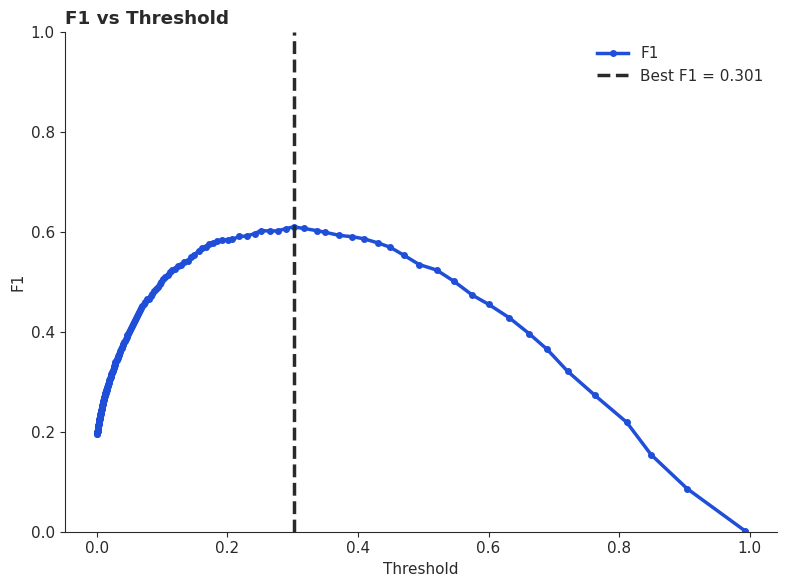

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

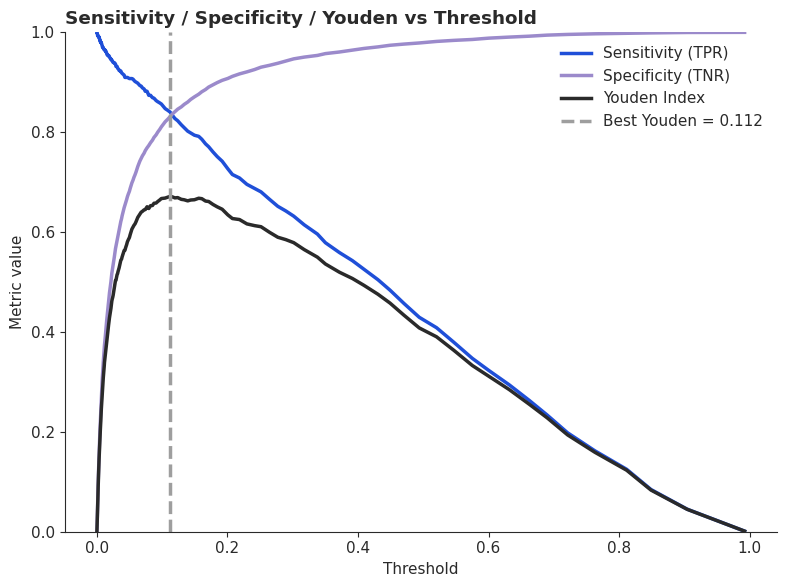

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

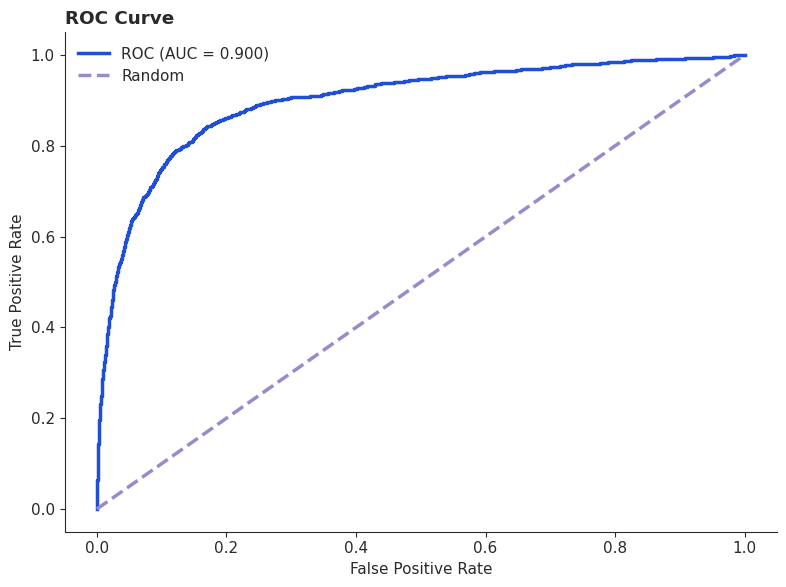

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

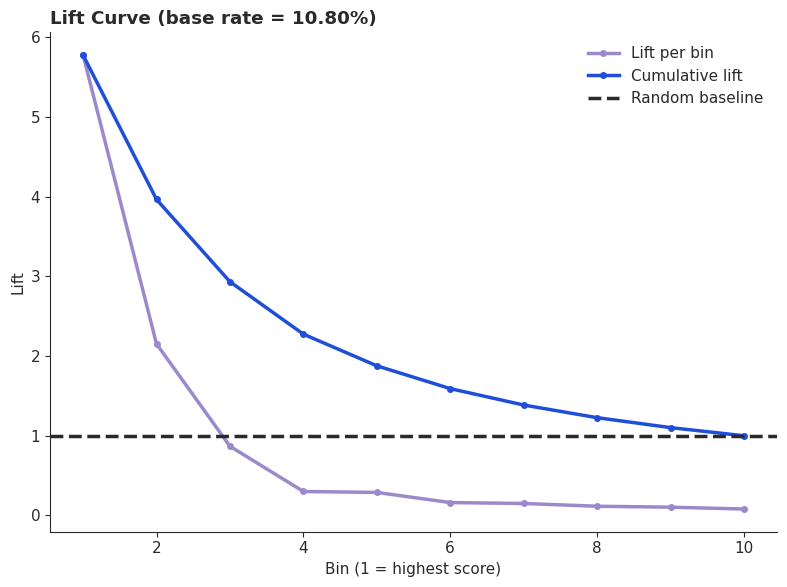

{'auc': 0.8999963344440292, 'base_rate': 0.108, 'best_threshold_f1': 0.3014735894057116, 'best_threshold_youden': 0.11218540522608222}


In [14]:
# run_demo.py
#from dummy_pkg import generate_dummy_binary_data_auc_09
#from plot_pkg import plot_model_diagnostics

if __name__ == "__main__":
    y_true, y_score, auc = generate_dummy_binary_data_auc_09(
        n_samples=8000,
        positive_rate=0.10,
        random_state=42,
    )
    print(f"Dummy generated: AUC={auc:.3f}, positive_rate={y_true.mean():.3f}")

    out = plot_model_diagnostics(
        y_true=y_true,
        y_score=y_score,
        n_thresholds=200,
        n_bins=10,
    )
    print(out)

In [15]:
import numpy as np

def _safe_div(a, b):
    return a / b if b != 0 else np.nan

def _metrics_at_threshold(y_true, y_score, t):
    y_pred = (y_score >= t).astype(int)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))

    precision = _safe_div(tp, tp + fp)
    recall = _safe_div(tp, tp + fn)            # sensitivity
    specificity = _safe_div(tn, tn + fp)
    f1 = _safe_div(2 * precision * recall, precision + recall)
    youden = recall + specificity - 1
    return f1, youden

def _best_over_thresholds(y_true, y_score, n_thresholds=200):
    # 用分位数阈值扫一遍，减少重复阈值 & 更稳
    qs = np.linspace(0, 1, n_thresholds)
    thresholds = np.unique(np.quantile(y_score, qs))

    f1s = np.empty_like(thresholds, dtype=float)
    js  = np.empty_like(thresholds, dtype=float)

    for i, t in enumerate(thresholds):
        f1, j = _metrics_at_threshold(y_true, y_score, t)
        f1s[i] = f1
        js[i] = j

    i_f1 = int(np.nanargmax(f1s))
    i_j  = int(np.nanargmax(js))

    return {
        "best_f1": float(f1s[i_f1]),
        "t_best_f1": float(thresholds[i_f1]),
        "best_youden": float(js[i_j]),
        "t_best_youden": float(thresholds[i_j]),
    }

def _lift_at_top_pct(y_true, y_score, top_pct=0.10):
    n = len(y_true)
    k = max(1, int(np.ceil(n * top_pct)))
    order = np.argsort(-y_score)
    top_idx = order[:k]
    base_rate = np.mean(y_true)
    top_rate = np.mean(y_true[top_idx])
    lift = _safe_div(top_rate, base_rate)
    return float(lift)

def bootstrap_ci_best_metrics(
    y_true,
    y_score,
    n_boot=500,
    ci=0.95,
    n_thresholds=200,
    lift_top_pct=0.10,
    seed=42,
):
    """
    Bootstrap CIs on one dataset (recommended: OOT window).
    Returns point estimates + (lower, upper) CI for:
      - best F1 and its threshold
      - best Youden and its threshold
      - Lift@TopX%
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    n = len(y_true)

    rng = np.random.default_rng(seed)

    # point estimates (on full sample)
    point = _best_over_thresholds(y_true, y_score, n_thresholds=n_thresholds)
    point["lift_top"] = _lift_at_top_pct(y_true, y_score, top_pct=lift_top_pct)

    # bootstrap distributions
    best_f1 = np.empty(n_boot, dtype=float)
    t_f1    = np.empty(n_boot, dtype=float)
    best_j  = np.empty(n_boot, dtype=float)
    t_j     = np.empty(n_boot, dtype=float)
    lift    = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)  # sample with replacement
        yt = y_true[idx]
        ys = y_score[idx]

        d = _best_over_thresholds(yt, ys, n_thresholds=n_thresholds)
        best_f1[b] = d["best_f1"]
        t_f1[b]    = d["t_best_f1"]
        best_j[b]  = d["best_youden"]
        t_j[b]     = d["t_best_youden"]
        lift[b]    = _lift_at_top_pct(yt, ys, top_pct=lift_top_pct)

    alpha = (1 - ci) / 2
    lo_q, hi_q = alpha, 1 - alpha

    def q(x):
        return (float(np.quantile(x, lo_q)), float(np.quantile(x, hi_q)))

    out = {
        "point": point,
        "ci": {
            "best_f1": q(best_f1),
            "t_best_f1": q(t_f1),
            "best_youden": q(best_j),
            "t_best_youden": q(t_j),
            f"lift_top_{int(lift_top_pct*100)}pct": q(lift),
        },
        # 如果你想做更深入诊断，可保留分布（可选）
        "dist": {
            "best_f1": best_f1,
            "t_best_f1": t_f1,
            "best_youden": best_j,
            "t_best_youden": t_j,
            "lift": lift,
        }
    }
    return out

In [16]:
res = bootstrap_ci_best_metrics(
    y_true,
    y_score,
    n_boot=500,
    ci=0.95,
    n_thresholds=200,
    lift_top_pct=0.10,  # 你也可以改 0.15 / 0.20
    seed=42,
)

print("Point estimates:")
print(res["point"])

print("\n95% CIs:")
for k, v in res["ci"].items():
    print(f"{k:>18}: ({v[0]:.4f}, {v[1]:.4f})")

Point estimates:
{'best_f1': 0.6103968697596422, 't_best_f1': 0.3014735894057116, 'best_youden': 0.6715558046836074, 't_best_youden': 0.11218540522608222, 'lift_top': 5.775462962962964}

95% CIs:
           best_f1: (0.5845, 0.6357)
         t_best_f1: (0.2478, 0.3439)
       best_youden: (0.6490, 0.7010)
     t_best_youden: (0.1007, 0.1661)
    lift_top_10pct: (5.4751, 6.0576)


In [17]:
import numpy as np

def recommend_threshold_ranges_from_ci(res, use_percentiles=(0.05, 0.5, 0.95)):
    """
    res: bootstrap_ci_best_metrics() 的返回结果（包含 dist + ci + point）
    use_percentiles: 用于取分位数的点（默认 5%, 50%, 95%）
    """
    # 取阈值分布
    t_f1_dist = res["dist"]["t_best_f1"]
    t_j_dist  = res["dist"]["t_best_youden"]

    p_lo, p_med, p_hi = use_percentiles
    tF1_lo, tF1_med, tF1_hi = np.quantile(t_f1_dist, [p_lo, p_med, p_hi])
    tJ_lo,  tJ_med,  tJ_hi  = np.quantile(t_j_dist,  [p_lo, p_med, p_hi])

    # 推荐区间
    high_range = (float(tJ_med), float(tJ_hi))
    watch_range = (float(tF1_lo), float(tJ_med))

    return {
        "watchlist_range": watch_range,
        "high_risk_range": high_range,
        "anchors": {
            "tF1_lo_med_hi": (float(tF1_lo), float(tF1_med), float(tF1_hi)),
            "tJ_lo_med_hi":  (float(tJ_lo),  float(tJ_med),  float(tJ_hi)),
            "lift_ci": res["ci"][next(k for k in res["ci"].keys() if k.startswith("lift_top_"))],
            "point": res["point"],
        }
    }

In [18]:
rec = recommend_threshold_ranges_from_ci(res)
print(rec)

{'watchlist_range': (0.25181541634651133, 0.11369330301461597), 'high_risk_range': (0.11369330301461597, 0.16220156403423575), 'anchors': {'tF1_lo_med_hi': (0.25181541634651133, 0.30048817243372394, 0.34009568273660773), 'tJ_lo_med_hi': (0.10257741817101693, 0.11369330301461597, 0.16220156403423575), 'lift_ci': (5.475091398075387, 6.057589923997291), 'point': {'best_f1': 0.6103968697596422, 't_best_f1': 0.3014735894057116, 'best_youden': 0.6715558046836074, 't_best_youden': 0.11218540522608222, 'lift_top': 5.775462962962964}}}


In [20]:
import pandas as pd

def rec_to_table(rec):
    """
    Convert recommend_threshold_ranges_from_ci(rec) output
    into a clean, decision-ready pandas DataFrame.
    """
    rows = [
        {
            "segment": "High risk",
            "threshold_range": f"[{rec['high_risk_range'][0]:.3f}, {rec['high_risk_range'][1]:.3f}]",
            "anchor": "Youden-optimal (upper band)",
            "interpretation": "High-confidence BCL risk; strong intervention"
        },
        {
            "segment": "Watchlist",
            "threshold_range": f"[{rec['watchlist_range'][0]:.3f}, {rec['watchlist_range'][1]:.3f})",
            "anchor": "F1-optimal lower CI → Youden median",
            "interpretation": "Potential risk; monitor / light intervention"
        },
        {
            "segment": "Low risk",
            "threshold_range": f"< {rec['watchlist_range'][0]:.3f}",
            "anchor": "Below F1-optimal CI lower bound",
            "interpretation": "Not prioritized under current capacity"
        }
    ]

    return pd.DataFrame(rows)

In [21]:
rec = recommend_threshold_ranges_from_ci(res)


df_rec = rec_to_table(rec)
df_rec

,segment,threshold_range,anchor,interpretation
0,High risk,"[0.114, 0.162]",Youden-optimal (upper band),High-confidence BCL risk; strong intervention
1,Watchlist,"[0.252, 0.114)",F1-optimal lower CI → Youden median,Potential risk; monitor / light intervention
2,Low risk,< 0.252,Below F1-optimal CI lower bound,Not prioritized under current capacity


In [ ]:
# ============================================================
# PART 1) Plot functions (diagnostic + F2 added; same jewel palette; no grid)
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score

# ---- Global visual constants ----
FIGSIZE = (8, 6)
LINE_WIDTH = 2.5
MARKER_SIZE = 4

# ---- Jewel-tone palette (original) ----
COLORS = {
    "sapphire_blue": "#1F4FD8",  # 宝石蓝
    "amethyst":      "#9B8ACB",  # 淡紫
    "charcoal":      "#2A2A2A",  # 高级黑
    "gray":          "#9E9E9E",  # 辅助灰
}

def set_jewel_style_no_grid():
    """Original jewel tone look, no grid, show x/y axes, uniform font."""
    plt.rcParams.update({
        "font.family": "Consolas",
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "axes.grid": False,

        # keep x/y axes visible
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,

        "axes.edgecolor": COLORS["charcoal"],
        "xtick.color": COLORS["charcoal"],
        "ytick.color": COLORS["charcoal"],
        "axes.labelcolor": COLORS["charcoal"],
        "text.color": COLORS["charcoal"],

        "legend.frameon": False,
        "font.size": 11,
        "xtick.direction": "out",
        "ytick.direction": "out",
    })

def _safe_div(a, b):
    return a / b if b != 0 else np.nan

def _fbeta(precision, recall, beta: float):
    b2 = beta * beta
    denom = b2 * precision + recall
    return ((1 + b2) * precision * recall / denom) if denom > 0 else 0.0

def _threshold_grid_from_scores(y_score, n_thresholds=200):
    qs = np.linspace(0.0, 1.0, n_thresholds)
    return np.unique(np.quantile(y_score, qs))

def _metrics_over_thresholds(y_true, y_score, thresholds):
    """
    Compute F1 and F2 over thresholds.
    Returns arrays: f1s, f2s
    """
    f1s = np.empty(len(thresholds), dtype=float)
    f2s = np.empty(len(thresholds), dtype=float)

    for i, t in enumerate(thresholds):
        y_pred = (y_score >= t).astype(int)

        tp = np.sum((y_true == 1) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))

        precision = _safe_div(tp, tp + fp)
        recall = _safe_div(tp, tp + fn)

        f1s[i] = _fbeta(precision, recall, beta=1.0)
        f2s[i] = _fbeta(precision, recall, beta=2.0)

    return f1s, f2s

def _lift_curve(y_true, y_score, n_bins=10):
    """
    Lift per bin + cumulative lift (by score descending).
    """
    order = np.argsort(-y_score)
    y_sorted = y_true[order]

    base_rate = float(np.mean(y_true))
    bins = np.array_split(y_sorted, n_bins)

    lifts, cum_lifts = [], []
    cum_pos, cum_n = 0, 0

    for b in bins:
        b_pos = np.sum(b == 1)
        b_n = len(b)
        b_rate = (b_pos / b_n) if b_n else np.nan
        lifts.append((b_rate / base_rate) if base_rate > 0 else np.nan)

        cum_pos += b_pos
        cum_n += b_n
        cum_rate = (cum_pos / cum_n) if cum_n else np.nan
        cum_lifts.append((cum_rate / base_rate) if base_rate > 0 else np.nan)

    x = np.arange(1, n_bins + 1)
    return x, np.asarray(lifts, float), np.asarray(cum_lifts, float), base_rate

def plot_model_diagnostics_with_f2(
    y_true,
    y_score,
    n_thresholds=200,
    n_bins=10,
):
    """
    Diagnostic plots (same as original) + F2 added:
      Plot 1: F1 & F2 vs Threshold (same chart)
      Plot 2: ROC
      Plot 3: Lift (per-bin + cumulative)

    Returns key points: AUC, base_rate, t_best_f1, t_best_f2, max_f1, max_f2
    """
    set_jewel_style_no_grid()

    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    thresholds = _threshold_grid_from_scores(y_score, n_thresholds=n_thresholds)
    f1s, f2s = _metrics_over_thresholds(y_true, y_score, thresholds)

    i_f1 = int(np.nanargmax(f1s))
    i_f2 = int(np.nanargmax(f2s))
    t_best_f1 = float(thresholds[i_f1])
    t_best_f2 = float(thresholds[i_f2])

    # -------------------------
    # Plot 1: F1 & F2 vs Threshold
    # -------------------------
    plt.figure(figsize=FIGSIZE)
    plt.plot(
        thresholds, f1s,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label="F1 (balanced)",
    )
    plt.plot(
        thresholds, f2s,
        color=COLORS["amethyst"],
        linewidth=LINE_WIDTH,
        label="F2 (recall-weighted)",
    )
    # vertical markers
    plt.axvline(
        t_best_f1,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label=f"F1-opt ≈ {t_best_f1:.3f}",
    )
    plt.axvline(
        t_best_f2,
        linestyle=":",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label=f"F2-opt ≈ {t_best_f2:.3f}",
    )
    plt.title("F1 & F2 vs Threshold (OOT recommended)", loc="left", weight="bold")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Plot 2: ROC
    # -------------------------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = float(roc_auc_score(y_true, y_score))

    plt.figure(figsize=FIGSIZE)
    plt.plot(
        fpr, tpr,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label=f"ROC (AUC = {auc:.3f})",
    )
    plt.plot(
        [0, 1], [0, 1],
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["amethyst"],
        label="Random",
    )
    plt.title("ROC Curve", loc="left", weight="bold")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Plot 3: Lift
    # -------------------------
    x, lifts, cum_lifts, base_rate = _lift_curve(y_true, y_score, n_bins=n_bins)

    plt.figure(figsize=FIGSIZE)
    plt.plot(
        x, lifts,
        color=COLORS["amethyst"],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=MARKER_SIZE,
        label="Lift per bin",
    )
    plt.plot(
        x, cum_lifts,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=MARKER_SIZE,
        label="Cumulative lift",
    )
    plt.axhline(
        1.0,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label="Random baseline",
    )
    plt.title(f"Lift Curve (base rate = {base_rate:.2%})", loc="left", weight="bold")
    plt.xlabel("Bin (1 = highest score)")
    plt.ylabel("Lift")
    plt.legend()
    plt.tight_layout()
    plt.show()



    

    return {
        "auc": auc,
        "base_rate": float(base_rate),
        "t_best_f1": t_best_f1,
        "t_best_f2": t_best_f2,
        "max_f1": float(f1s[i_f1]),
        "max_f2": float(f2s[i_f2]),
    }


# ============================================================
# PART 2) Input y_true, y_score -> run plots (example usage)
# ============================================================
# Example:
# out = plot_model_diagnostics_with_f2(y_true_oot, y_score_oot, n_thresholds=200, n_bins=10)
# print(out)


# ============================================================
# PART 3) Recommendation threshold CI (bootstrap) using ONLY F1, F2, Lift
#         Output a pandas DataFrame
# ============================================================
def _lift_at_top_pct(y_true, y_score, top_pct=0.10):
    n = len(y_true)
    k = max(1, int(np.ceil(n * top_pct)))
    order = np.argsort(-y_score)
    top_idx = order[:k]
    base_rate = float(np.mean(y_true))
    top_rate = float(np.mean(y_true[top_idx]))
    return float(_safe_div(top_rate, base_rate))

def _best_threshold_for_metric(y_true, y_score, metric: str, n_thresholds=200):
    thresholds = _threshold_grid_from_scores(y_score, n_thresholds=n_thresholds)
    f1s, f2s = _metrics_over_thresholds(y_true, y_score, thresholds)

    if metric.lower() == "f1":
        idx = int(np.nanargmax(f1s))
        return float(thresholds[idx]), float(f1s[idx])
    if metric.lower() == "f2":
        idx = int(np.nanargmax(f2s))
        return float(thresholds[idx]), float(f2s[idx])

    raise ValueError("metric must be 'f1' or 'f2'")

def recommendation_threshold_ci(
    y_true,
    y_score,
    n_boot=500,
    ci=0.95,
    n_thresholds=200,
    lift_top_pct=0.10,
    seed=42,
):
    """
    Bootstrap CIs on ONE dataset (recommended: OOT window):
      - F1-opt threshold and best F1
      - F2-opt threshold and best F2
      - Lift@TopX% (threshold-independent)

    Returns:
      df (pandas DataFrame) with point + CI.
    """
    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)
    n = len(y_true)

    rng = np.random.default_rng(seed)
    alpha = (1 - ci) / 2
    lo_q, hi_q = alpha, 1 - alpha

    # ----- point estimates on full sample -----
    t_f1_point, f1_point = _best_threshold_for_metric(y_true, y_score, "f1", n_thresholds=n_thresholds)
    t_f2_point, f2_point = _best_threshold_for_metric(y_true, y_score, "f2", n_thresholds=n_thresholds)
    lift_point = _lift_at_top_pct(y_true, y_score, top_pct=lift_top_pct)

    # ----- bootstrap distributions -----
    t_f1_dist = np.empty(n_boot, dtype=float)
    f1_dist   = np.empty(n_boot, dtype=float)
    t_f2_dist = np.empty(n_boot, dtype=float)
    f2_dist   = np.empty(n_boot, dtype=float)
    lift_dist = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)  # sample with replacement
        yt = y_true[idx]
        ys = y_score[idx]

        t_f1_dist[b], f1_dist[b] = _best_threshold_for_metric(yt, ys, "f1", n_thresholds=n_thresholds)
        t_f2_dist[b], f2_dist[b] = _best_threshold_for_metric(yt, ys, "f2", n_thresholds=n_thresholds)
        lift_dist[b] = _lift_at_top_pct(yt, ys, top_pct=lift_top_pct)

    def _ci_bounds(arr):
        return float(np.quantile(arr, lo_q)), float(np.quantile(arr, hi_q))

    # ----- build output df -----
    rows = [
        {
            "metric": "threshold_f1_opt",
            "point": t_f1_point,
            "ci_low": _ci_bounds(t_f1_dist)[0],
            "ci_high": _ci_bounds(t_f1_dist)[1],
            "notes": "Threshold that maximizes F1 (balanced)."
        },
        {
            "metric": "best_f1",
            "point": f1_point,
            "ci_low": _ci_bounds(f1_dist)[0],
            "ci_high": _ci_bounds(f1_dist)[1],
            "notes": "Max F1 at threshold_f1_opt."
        },
        {
            "metric": "threshold_f2_opt",
            "point": t_f2_point,
            "ci_low": _ci_bounds(t_f2_dist)[0],
            "ci_high": _ci_bounds(t_f2_dist)[1],
            "notes": "Threshold that maximizes F2 (recall-weighted)."
        },
        {
            "metric": "best_f2",
            "point": f2_point,
            "ci_low": _ci_bounds(f2_dist)[0],
            "ci_high": _ci_bounds(f2_dist)[1],
            "notes": "Max F2 at threshold_f2_opt."
        },
        {
            "metric": f"lift_top_{int(lift_top_pct*100)}pct",
            "point": lift_point,
            "ci_low": _ci_bounds(lift_dist)[0],
            "ci_high": _ci_bounds(lift_dist)[1],
            "notes": "Lift based on ranking (threshold-independent)."
        },
    ]

    df = pd.DataFrame(rows)
    return df


# Example:
# df_ci = recommendation_threshold_ci(
#     y_true_oot, y_score_oot,
#     n_boot=500, ci=0.95,
#     n_thresholds=200,
#     lift_top_pct=0.10,
#     seed=42
# )
# print(df_ci)

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

Dummy generated: AUC=0.900, positive_rate=0.108


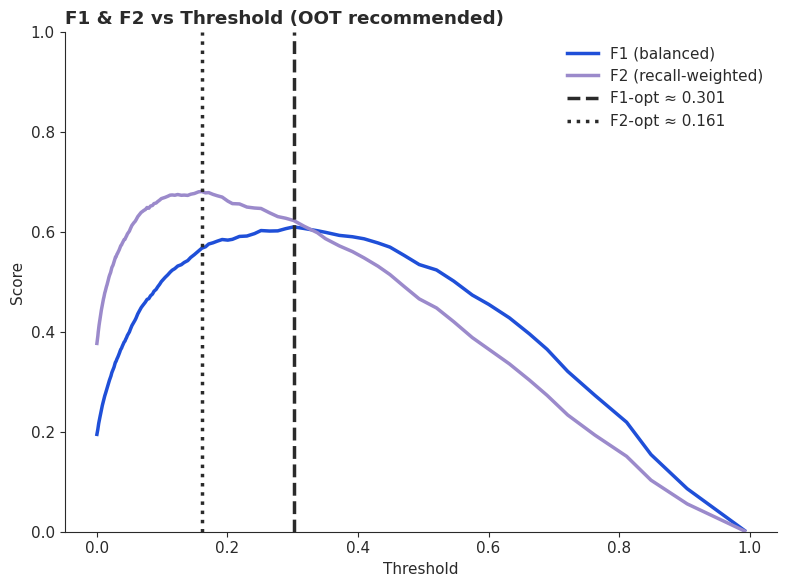

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

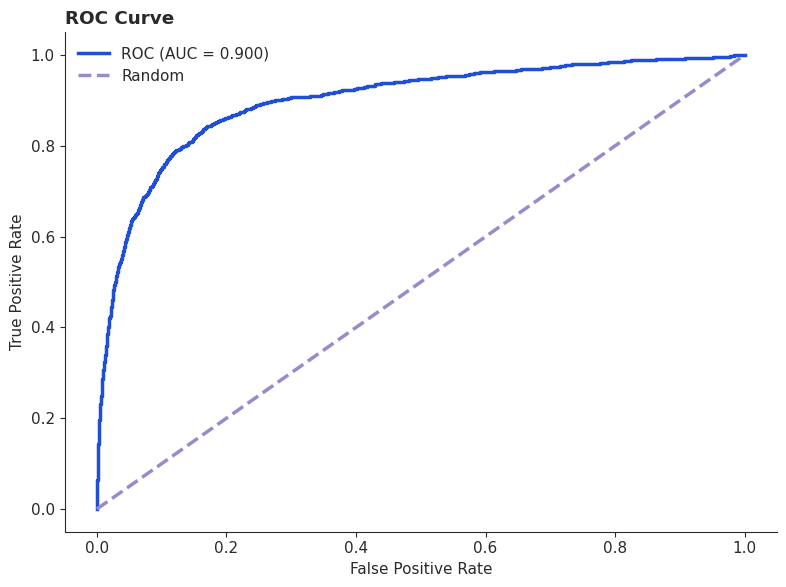

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

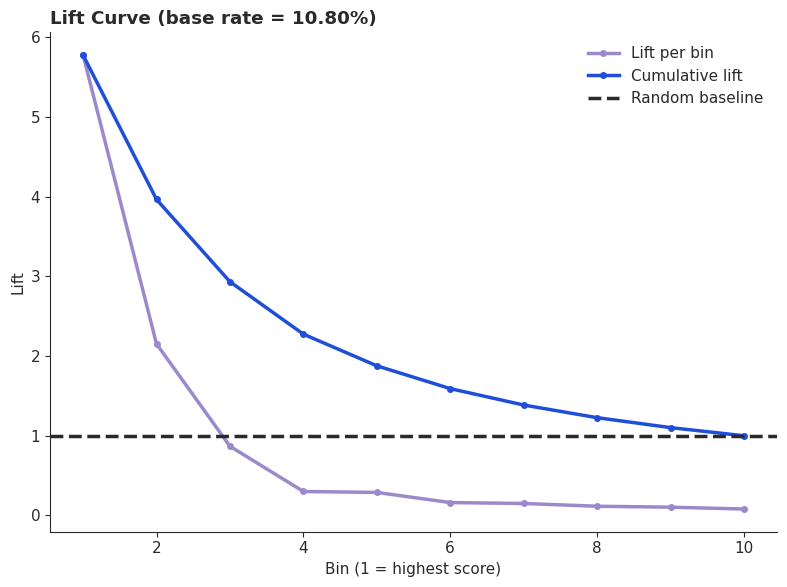

{'auc': 0.8999963344440292, 'base_rate': 0.108, 't_best_f1': 0.3014735894057116, 't_best_f2': 0.16071272715048646, 'max_f1': 0.6103968697596422, 'max_f2': 0.681179775280899}


In [25]:
if __name__ == "__main__":
    y_true, y_score, auc = generate_dummy_binary_data_auc_09(
        n_samples=8000,
        positive_rate=0.10,
        random_state=42,
    )
    print(f"Dummy generated: AUC={auc:.3f}, positive_rate={y_true.mean():.3f}")

    out = plot_model_diagnostics_with_f2(
        y_true=y_true,
        y_score=y_score,
        n_thresholds=200,
        n_bins=10,
    )
    print(out)

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

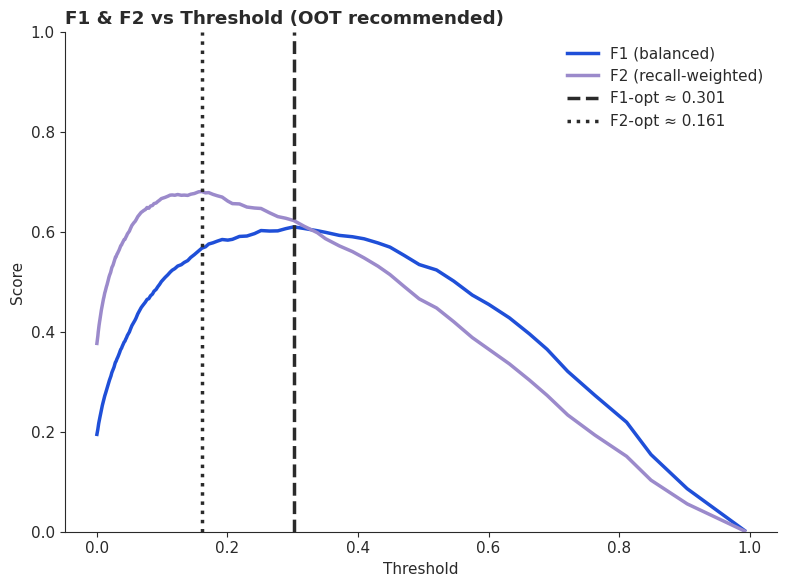

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

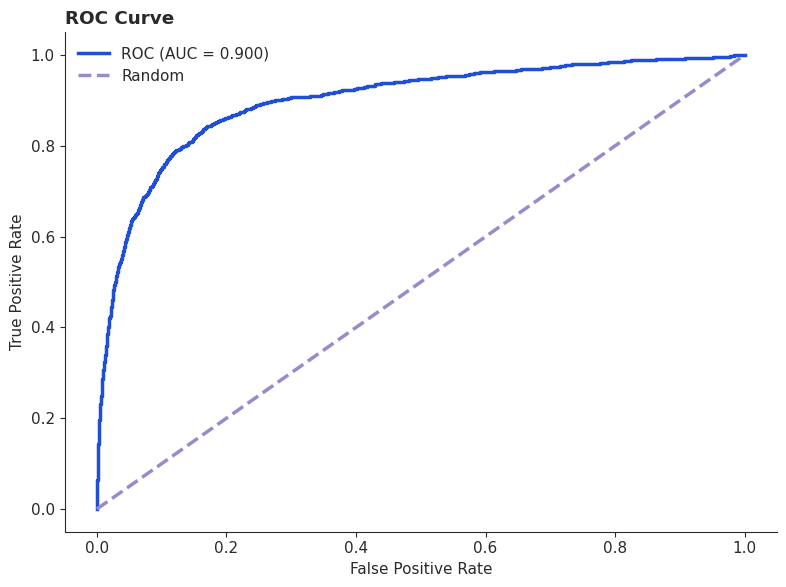

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

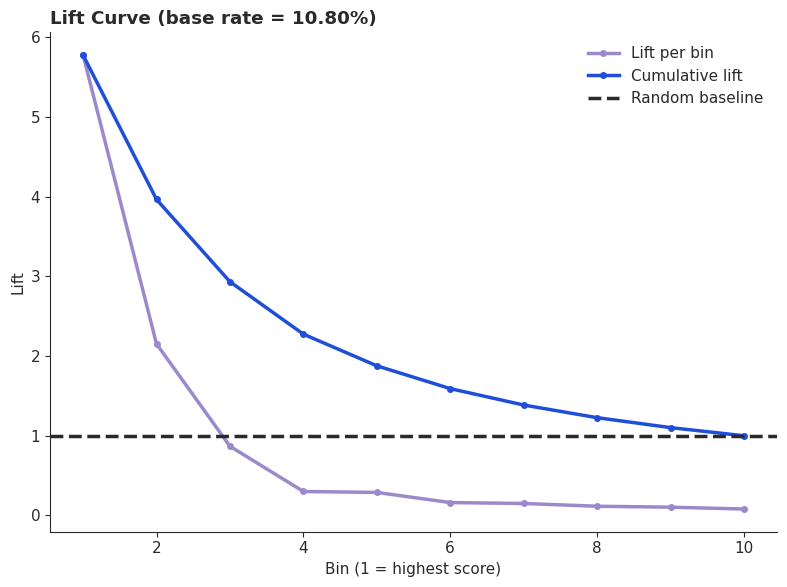

{'auc': 0.8999963344440292, 'base_rate': 0.108, 't_best_f1': 0.3014735894057116, 't_best_f2': 0.16071272715048646, 'max_f1': 0.6103968697596422, 'max_f2': 0.681179775280899}


In [26]:
ut = plot_model_diagnostics_with_f2(y_true, y_score)
print(out)

In [28]:
df_ci = recommendation_threshold_ci(y_true, y_score, n_boot=500, lift_top_pct=0.10)
print(df_ci)

             metric     point    ci_low   ci_high  \
0  threshold_f1_opt  0.301474  0.247789  0.343931   
1           best_f1  0.610397  0.584476  0.635733   
2  threshold_f2_opt  0.160713  0.112094  0.183022   
3           best_f2  0.681180  0.657810  0.704550   
4    lift_top_10pct  5.775463  5.475091  6.057590   

                                            notes  
0         Threshold that maximizes F1 (balanced).  
1                     Max F1 at threshold_f1_opt.  
2  Threshold that maximizes F2 (recall-weighted).  
3                     Max F2 at threshold_f2_opt.  
4  Lift based on ranking (threshold-independent).  


In [29]:
df_ci

,metric,point,ci_low,ci_high,notes
0,threshold_f1_opt,0.301474,0.247789,0.343931,Threshold that maximizes F1 (balanced).
1,best_f1,0.610397,0.584476,0.635733,Max F1 at threshold_f1_opt.
2,threshold_f2_opt,0.160713,0.112094,0.183022,Threshold that maximizes F2 (recall-weighted).
3,best_f2,0.681180,0.657810,0.704550,Max F2 at threshold_f2_opt.
4,lift_top_10pct,5.775463,5.475091,6.057590,Lift based on ranking (threshold-independent).


In [32]:
def plot_lift_vs_threshold_with_markers(
    y_true,
    y_score,
    thresholds_to_mark=(0.725, 0.8),
    n_thresholds=200,
    min_selected=30,
):
    """
    Threshold-based Lift chart with marked thresholds.
    Marks lift & coverage at specified thresholds (e.g., 0.725, 0.8).
    """
    set_jewel_style_no_grid()

    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    base_rate = float(np.mean(y_true))
    n = len(y_true)

    thresholds = _threshold_grid_from_scores(y_score, n_thresholds=n_thresholds)
    lifts = np.full(len(thresholds), np.nan)
    coverages = np.full(len(thresholds), np.nan)

    for i, t in enumerate(thresholds):
        sel = (y_score >= t)
        n_sel = int(np.sum(sel))
        coverages[i] = n_sel / n if n > 0 else np.nan

        if n_sel < max(1, min_selected):
            continue

        sel_rate = float(np.mean(y_true[sel]))
        lifts[i] = sel_rate / base_rate if base_rate > 0 else np.nan

    # -------------------------
    # Main lift plot
    # -------------------------
    plt.figure(figsize=FIGSIZE)
    plt.plot(
        thresholds, lifts,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label="Lift(t)",
    )
    plt.axhline(
        1.0,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label="Random baseline",
    )

    # -------------------------
    # Mark specific thresholds
    # -------------------------
    for t in thresholds_to_mark:
        idx = np.nanargmin(np.abs(thresholds - t))
        lift_t = lifts[idx]
        cov_t = coverages[idx]

        plt.axvline(
            thresholds[idx],
            linestyle=":",
            linewidth=LINE_WIDTH,
            color=COLORS["amethyst"],
        )

        plt.scatter(
            thresholds[idx],
            lift_t,
            color=COLORS["charcoal"],
            zorder=5,
        )

        plt.text(
            thresholds[idx],
            lift_t,
            f"  t={thresholds[idx]:.3f}\n  lift={lift_t:.2f}\n  cov={cov_t:.1%}",
            fontsize=10,
            verticalalignment="bottom",
            color=COLORS["charcoal"],
        )

    plt.title("Lift vs Threshold (OOT)", loc="left", weight="bold")
    plt.xlabel("Threshold")
    plt.ylabel("Lift")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "base_rate": base_rate,
        "thresholds": thresholds,
        "lift": lifts,
        "coverage": coverages,
    }

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

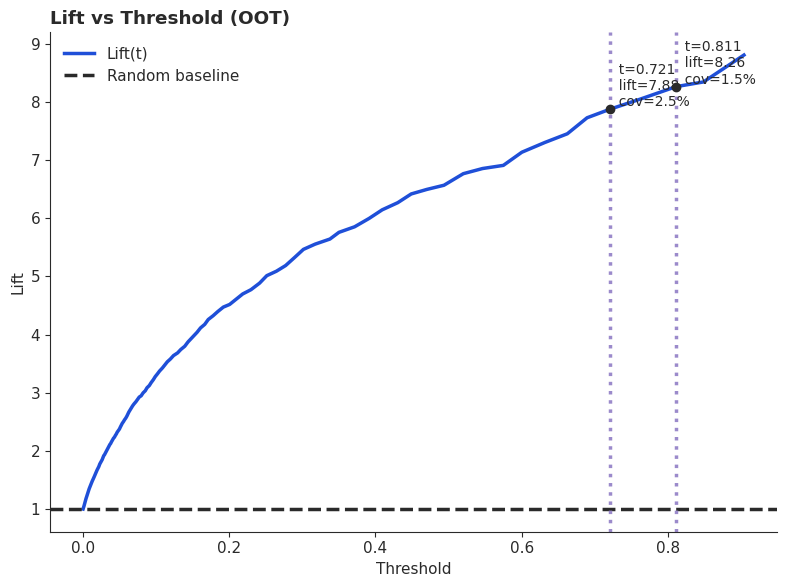

In [33]:
lift_out = plot_lift_vs_threshold_with_markers(
y_true,
y_score,
thresholds_to_mark=(0.725, 0.8),
)

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

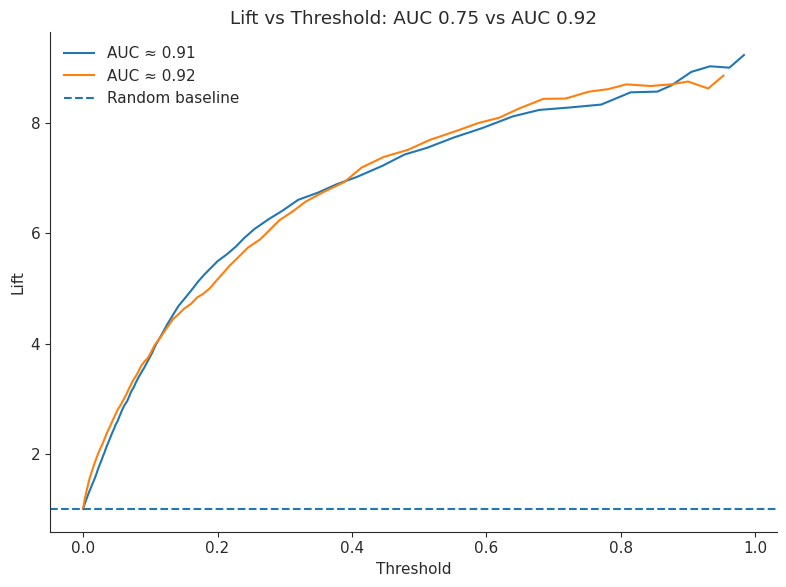

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def gen_scores(class_sep, n=12000, pos_rate=0.1, seed=0):
    X, y = make_classification(
        n_samples=n,
        n_features=20,
        n_informative=8,
        n_redundant=4,
        weights=[1 - pos_rate, pos_rate],
        class_sep=class_sep,
        flip_y=0.02,
        random_state=seed,
    )
    model = LogisticRegression(max_iter=3000)
    model.fit(X, y)
    s = model.predict_proba(X)[:, 1]
    return y, s, roc_auc_score(y, s)

def lift_vs_threshold(y_true, y_score, n_thresholds=200, min_selected=50):
    thresholds = np.unique(np.quantile(y_score, np.linspace(0, 1, n_thresholds)))
    base_rate = y_true.mean()
    lifts = []
    for t in thresholds:
        sel = y_score >= t
        if sel.sum() < min_selected:
            lifts.append(np.nan)
        else:
            lifts.append(y_true[sel].mean() / base_rate)
    return thresholds, np.array(lifts)

# ---- Generate two models ----
y75, s75, auc75 = gen_scores(class_sep=1.0, seed=7)    # ~AUC 0.75
y92, s92, auc92 = gen_scores(class_sep=2.0, seed=42)   # ~AUC 0.92

# ---- Compute lift curves ----
t75, l75 = lift_vs_threshold(y75, s75)
t92, l92 = lift_vs_threshold(y92, s92)

# ---- Plot ----
plt.figure(figsize=(8, 6))
plt.plot(t75, l75, label=f"AUC ≈ {auc75:.2f}")
plt.plot(t92, l92, label=f"AUC ≈ {auc92:.2f}")
plt.axhline(1.0, linestyle="--", label="Random baseline")
plt.xlabel("Threshold")
plt.ylabel("Lift")
plt.title("Lift vs Threshold: AUC 0.75 vs AUC 0.92")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
def plot_lift_f1_vs_coverage(
    y_true,
    y_score,
    n_points=200,
    min_selected=30,
    thresholds_to_mark=(0.725, 0.8),
):
    """
    Combined decision chart:
      - x-axis: Coverage
      - left y-axis: Lift
      - right y-axis: F1

    This is the final decision chart for threshold / segmentation.
    """
    set_jewel_style_no_grid()

    y_true = np.asarray(y_true).astype(int)
    y_score = np.asarray(y_score).astype(float)

    n = len(y_true)
    if n == 0:
        raise ValueError("Empty input.")

    base_rate = float(np.mean(y_true))
    total_pos = int(y_true.sum())
    if base_rate == 0 or total_pos == 0:
        raise ValueError("No positive samples in y_true.")

    # sort by score desc
    order = np.argsort(-y_score)
    y_sorted = y_true[order]

    # coverage grid
    cov_grid = np.linspace(1 / n, 1.0, n_points)
    ks = np.clip((cov_grid * n).astype(int), 1, n)

    # cumulative positives
    cum_pos = np.cumsum(y_sorted)

    lifts = np.full_like(cov_grid, np.nan, dtype=float)
    f1s = np.full_like(cov_grid, np.nan, dtype=float)

    for i, k in enumerate(ks):
        if k < max(1, min_selected):
            continue

        tp = cum_pos[k - 1]
        fp = k - tp
        fn = total_pos - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        # Lift
        lifts[i] = (precision / base_rate) if base_rate > 0 else np.nan

        # F1
        if precision + recall > 0:
            f1s[i] = 2 * precision * recall / (precision + recall)

    # -------------------------
    # Plot
    # -------------------------
    fig, ax1 = plt.subplots(figsize=FIGSIZE)

    # Lift (left axis)
    ax1.plot(
        cov_grid, lifts,
        color=COLORS["sapphire_blue"],
        linewidth=LINE_WIDTH,
        label="Lift",
    )
    ax1.axhline(
        1.0,
        linestyle="--",
        linewidth=LINE_WIDTH,
        color=COLORS["charcoal"],
        label="Random baseline",
    )
    ax1.set_xlabel("Coverage (fraction selected)")
    ax1.set_ylabel("Lift", color=COLORS["sapphire_blue"])
    ax1.tick_params(axis="y", labelcolor=COLORS["sapphire_blue"])

    # F1 (right axis)
    ax2 = ax1.twinx()
    ax2.plot(
        cov_grid, f1s,
        color=COLORS["amethyst"],
        linewidth=LINE_WIDTH,
        label="F1",
    )
    ax2.set_ylabel("F1 score", color=COLORS["amethyst"])
    ax2.tick_params(axis="y", labelcolor=COLORS["amethyst"])
    ax2.set_ylim(0, 1)

    # -------------------------
    # Mark thresholds
    # -------------------------
    marker_info = []

    for t in thresholds_to_mark or []:
        sel = (y_score >= t)
        k = int(sel.sum())
        if k < max(1, min_selected):
            continue

        cov_t = k / n
        tp = int(np.sum(y_true[sel]))
        fp = k - tp
        fn = total_pos - tp

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        lift_t = precision / base_rate
        f1_t = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else np.nan

        ax1.scatter(cov_t, lift_t, color=COLORS["sapphire_blue"], s=60, zorder=5)
        ax2.scatter(cov_t, f1_t, color=COLORS["amethyst"], s=60, zorder=5)

        ax1.text(
            cov_t, lift_t,
            f"  t={t:.3f}\n  cov={cov_t:.1%}\n  lift={lift_t:.2f}",
            fontsize=10,
            color=COLORS["charcoal"],
            va="bottom",
        )

        marker_info.append({
            "threshold": float(t),
            "coverage": float(cov_t),
            "lift": float(lift_t),
            "f1": float(f1_t),
            "k": k,
        })

    # Title & legend
    fig.suptitle("Lift & F1 vs Coverage (OOT)", x=0.05, ha="left", weight="bold")

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    fig.tight_layout()
    plt.show()

    return {
        "coverage": cov_grid,
        "lift": lifts,
        "f1": f1s,
        "markers": marker_info,
        "base_rate": base_rate,
    }



findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

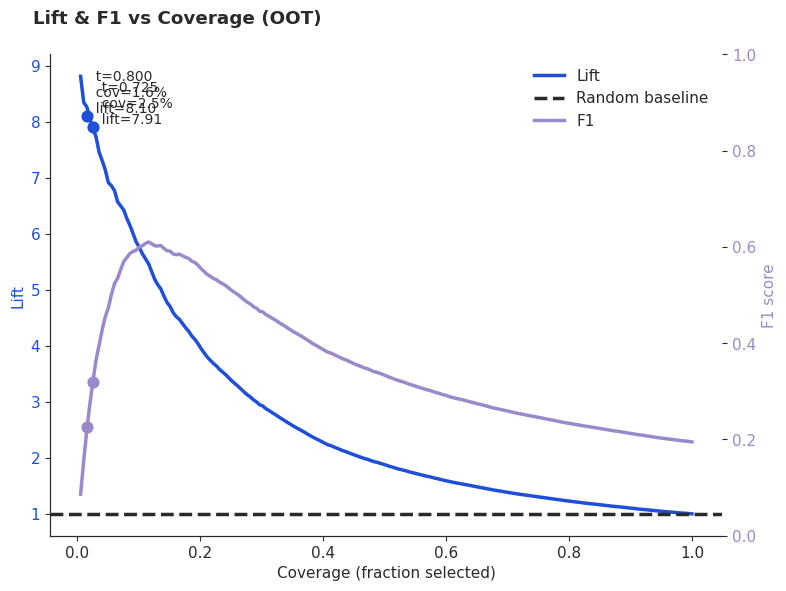

[{'threshold': 0.725, 'coverage': 0.024875, 'lift': 7.909919970221478, 'f1': 0.31984948259642526, 'k': 199}, {'threshold': 0.8, 'coverage': 0.016, 'lift': 8.101851851851851, 'f1': 0.22580645161290322, 'k': 128}]


In [39]:
decision_out = plot_lift_f1_vs_coverage(
    y_true,
    y_score,
    thresholds_to_mark=(0.725, 0.8)
)

print(decision_out["markers"])

In [ ]:
import json
import numpy as np
import pandas as pd

def _to_dict(x):
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            return {}
    return {}

def build_global_shap_table(
    df,
    explanation_col="explanations",
    id_col="store_id",
    top_n=50
):
    """
    df: DSS scoring output (1 row per id)
    explanation_col: JSON/dict col: {feature: influence}
    Returns: global feature table with importance + direction.
    """
    # Parse explanations into wide table: cols=features, rows=ids
    expl_series = df[explanation_col].apply(_to_dict)
    shap_wide = pd.json_normalize(expl_series)  # columns: feature names

    # Compute global summary
    rows = []
    for feat in shap_wide.columns:
        s = pd.to_numeric(shap_wide[feat], errors="coerce")
        if s.notna().sum() == 0:
            continue
        rows.append({
            "feature": feat,
            "mean_abs_influence": float(np.nanmean(np.abs(s))),  # global importance
            "mean_influence": float(np.nanmean(s)),              # global direction
            "pct_positive": float(np.nanmean(s > 0)),
            "pct_negative": float(np.nanmean(s < 0)),
        })

    out = (pd.DataFrame(rows)
             .sort_values("mean_abs_influence", ascending=False)
             .reset_index(drop=True))

    if top_n is not None:
        out = out.head(top_n)

    return out